In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import h5py
import pywt
import seaborn as sns
import mp_utils as mp
import importlib
import librosa
import random
import soundfile as sf
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from scipy.signal import spectrogram
from matplotlib.colors import Normalize
from collections import defaultdict
from scipy.stats import entropy
from tqdm import tqdm
from scipy import stats    
from matplotlib.colors import LinearSegmentedColormap
import csv
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.signal import periodogram
from collections import Counter
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')
importlib.reload(mp)


c:\Users\alexa\Documents\1Alexandra\delft\y3\ResearchProject\code\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'mp_utils' from 'c:\\Users\\alexa\\Documents\\1Alexandra\\delft\\y3\\ResearchProject\\code\\mp_utils.py'>

In [2]:
import os
import pandas as pd
from julia.api import Julia
jl = Julia(compiled_modules=False)

from julia import Main

# Import JLD2 explicitly inside Julia Main
Main.eval("using JLD2")
Main.eval("const jlJLD2 = JLD2")
print("jlJLD2" in Main.eval("names(Main)"))


# Include your custom Julia functions
Main.include("C:/Users/alexa/Documents/1Alexandra/delft/y3/ResearchProject/encoding/mp_utils.jl")  # <-- Adjust path if needed


True


<PyCall.jlwrap Main.mp_utils>

In [6]:
import os
import pandas as pd
import traceback
from tqdm import tqdm
from julia import Main

def convert_jld2_folder_to_csv(folder_path, output_csv="combined_activations.csv"):

    jld2_files = [f for f in os.listdir(folder_path) if f.endswith(".jld2")]
    first_chunk = True  # To write header only once

    for fname in tqdm(jld2_files):
        full_path = os.path.join(folder_path, fname)
        try:
            path_julia = full_path.replace("\\", "/")
            data = Main.eval(f'JLD2.load("{path_julia}")')

            kernel_list = data.get("kernel_list", None)
            amp_list = data.get("amp_list", None)
            index_list = data.get("index_list", None)

            if kernel_list is not None and amp_list is not None and index_list is not None:
                chunk_data = []

                # Clean the filename inline
                clean_fname = '_'.join(fname.split('_')[1:]).replace('.jld2', '.wav')

                for k, a, idx in zip(kernel_list, amp_list, index_list):
                    chunk_data.append({
                        "filename": clean_fname,
                        "kernel": k,
                        "amplitude": a,
                        "time": idx
                    })

                chunk_df = pd.DataFrame(chunk_data)

                # Write to CSV incrementally, header only for first chunk
                chunk_df.to_csv(output_csv, mode='w' if first_chunk else 'a',
                                header=first_chunk, index=False)
                first_chunk = False

        except Exception as e:
            print(f"Error processing {fname}: {e}")
            traceback.print_exc()

    print(f"Saved all data incrementally to {output_csv}")


In [180]:
convert_jld2_folder_to_csv("encoded/Results_rp_f", output_csv="RP_activations_res.csv")

100%|██████████| 1476/1476 [07:26<00:00,  3.30it/s]

Saved all data incrementally to RP_activations_res.csv


In [ ]:
convert_jld2_folder_to_csv("encoded/Results_ra_f", output_csv="RA_activations.csv")

100%|██████████| 5907/5907 [04:10<00:00, 23.62it/s]

Saved all data incrementally to RA_activations2.csv


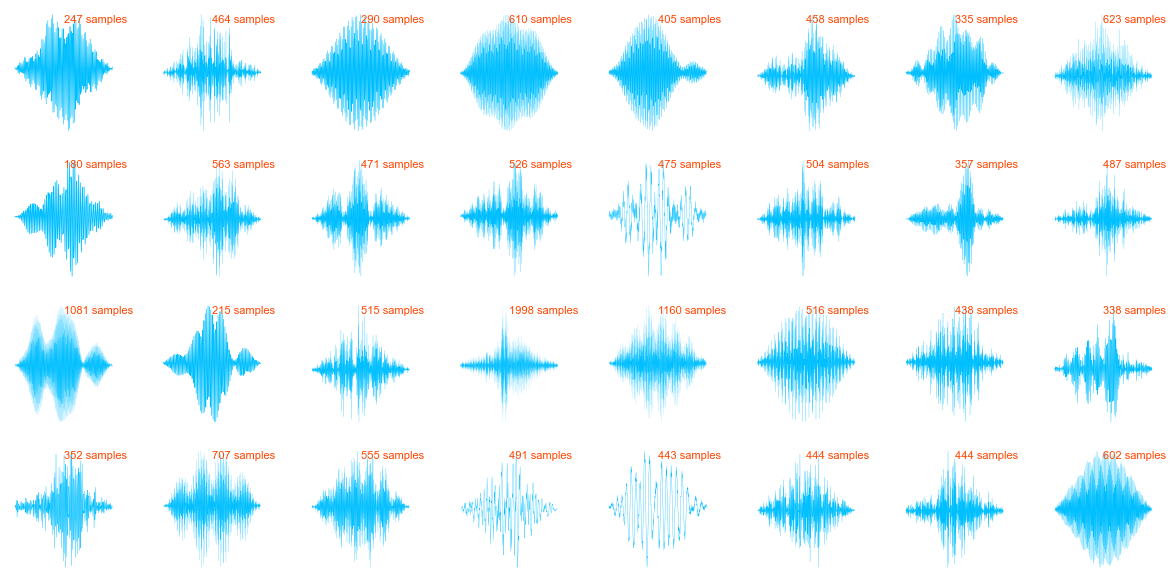

In [10]:
learned_dictionary = mp.create_dictionary_from_JLD2("kernels_high_400_10000.jld2")
mp.plot_dictionary_elements(learned_dictionary)

In [ ]:
def plot_kernels_with_activation(dictionary, activation_counts, num_files, max_kernels=32, cluster=None, ids=None):
    def clipped_colormap(base_cmap, minval=0.1, maxval=0.95, n=256):
        new_colors = base_cmap(np.linspace(minval, maxval, n))
        return LinearSegmentedColormap.from_list(f"{base_cmap.name}_clipped", new_colors)

    plt.rcParams.update({
        "axes.edgecolor": "#444444",
        "grid.color": "#cccccc",
        "grid.linewidth": 0.8,
        "legend.frameon": False,
        "mathtext.fontset": "cm",
        "font.family": "DejaVu Sans",
    })

    cmap = clipped_colormap(plt.cm.plasma)
    activation_counts = np.array(activation_counts)
    normalized_activations = activation_counts / activation_counts.max()
    colors = cmap(normalized_activations)
    n_plot = len(dictionary)

    fig = plt.figure(figsize=(14, 10))
    outer_grid = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.15)

    top_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[0],
                                                width_ratios=[1, 0.015], wspace=0.15)
    main_ax = plt.Subplot(fig, top_grid[0])
    main_ax.grid(False)
    main_ax.axis('off')
    fig.add_subplot(main_ax)

    rows = 4
    cols = max_kernels // rows
    inner_grid = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=top_grid[0], wspace=0.3, hspace=0.3)

    for i in range(n_plot):
        ax = fig.add_subplot(inner_grid[i])
        kernel = dictionary[i].kernel
        kernel_length = len(kernel)
        ax.plot(kernel, linewidth=100.0 / kernel_length, color=colors[i])
        ax.text(0.1, 0.9, f"{ + 1}", fontsize=20, transform=ax.transAxes)
        ax.axis('off')

    cbar_ax = plt.Subplot(fig, top_grid[1])
    norm = plt.Normalize(vmin=activation_counts.min(), vmax=activation_counts.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label("Activation Count (×10³)", fontsize=26)

    ticks = cbar.ax.get_yticks()
    cbar.ax.set_yticklabels([f"{tick / 1000:.0f}" for tick in ticks])
    cbar.ax.tick_params(labelsize=22)

    fig.add_subplot(cbar_ax)

    bottom_ax = fig.add_subplot(outer_grid[1])
    bar_positions = np.arange(n_plot) + 1
    bottom_ax.bar(bar_positions, activation_counts / 1000.0, color=colors)
    bottom_ax.set_xticks(bar_positions)
    bottom_ax.set_xticklabels(bar_positions, rotation=90, fontsize=22)
    bottom_ax.set_xlabel("Sorted Kernel Index", fontsize=26)
    bottom_ax.set_ylabel("     Activation Count (×10³)", fontsize=26)
    bottom_ax.set_title(
        f"Matching Pursuit Activations Across R. affinis Echolocation Calls" +
        (f" from Cluster {cluster}" if cluster is not None else ""), fontsize=24)
    bottom_ax.tick_params(axis='y', labelsize=22)
    bottom_ax.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

    return fig


In [4]:
def get_activation_counts(df, top_n=None, dict_size=32):
    # Select top-N by amplitude per filename using groupby and nlargest (faster than sort + head)
    if (top_n != None):
      df = (
          df.groupby('filename', group_keys=False)
            .apply(lambda g: g.nlargest(top_n, 'amplitude'))
      )       

    # Adjust kernel indexing if needed
    kernel_indices = df['kernel'].values - 1  # Assuming kernel starts at 1

    # Use np.bincount with minlength to zero-pad up to dict_size
    activation_counts = np.bincount(kernel_indices, minlength=dict_size)

    # Sort counts descending
    sorted_indices = np.argsort(-activation_counts)
    sorted_counts = activation_counts[sorted_indices]

    return sorted_counts, sorted_indices


In [5]:
csv_path = "RA_activations.csv"
df = pd.read_csv(csv_path)
learned_dictionary = mp.create_dictionary_from_JLD2("kernels_high_400_10000.jld2")

In [48]:
activation_counts_all, sorted_indices_all = get_activation_counts(df)
sorted_dictionary_all = [learned_dictionary[i] for i in sorted_indices_all]

In [44]:
activation_counts, sorted_indices = get_activation_counts(df, top_n=70)
sorted_dictionary = [learned_dictionary[i] for i in sorted_indices]

C:\Users\alexa\AppData\Local\Temp\ipykernel_16232\1086083401.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(top_n, 'amplitude'))


In [53]:
csv_path_p = "RP_activations.csv"
df_p = pd.read_csv(csv_path_p)
learned_dictionary = mp.create_dictionary_from_JLD2("kernels_high_400_10000.jld2")
activation_counts_p, sorted_indices_p = get_activation_counts(df_p, dict_size=len(learned_dictionary))
sorted_dictionary_p = [learned_dictionary[i] for i in sorted_indices_p]

In [61]:
top70_rank_map = {k: i for i, k in enumerate(sorted_indices)}
top70_based_ids = [top70_rank_map[i] for i in sorted_indices_all]

C:\Users\alexa\AppData\Local\Temp\ipykernel_16232\2070435761.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([f"{tick / 1000:.0f}" for tick in ticks])
C:\Users\alexa\AppData\Local\Temp\ipykernel_16232\2070435761.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


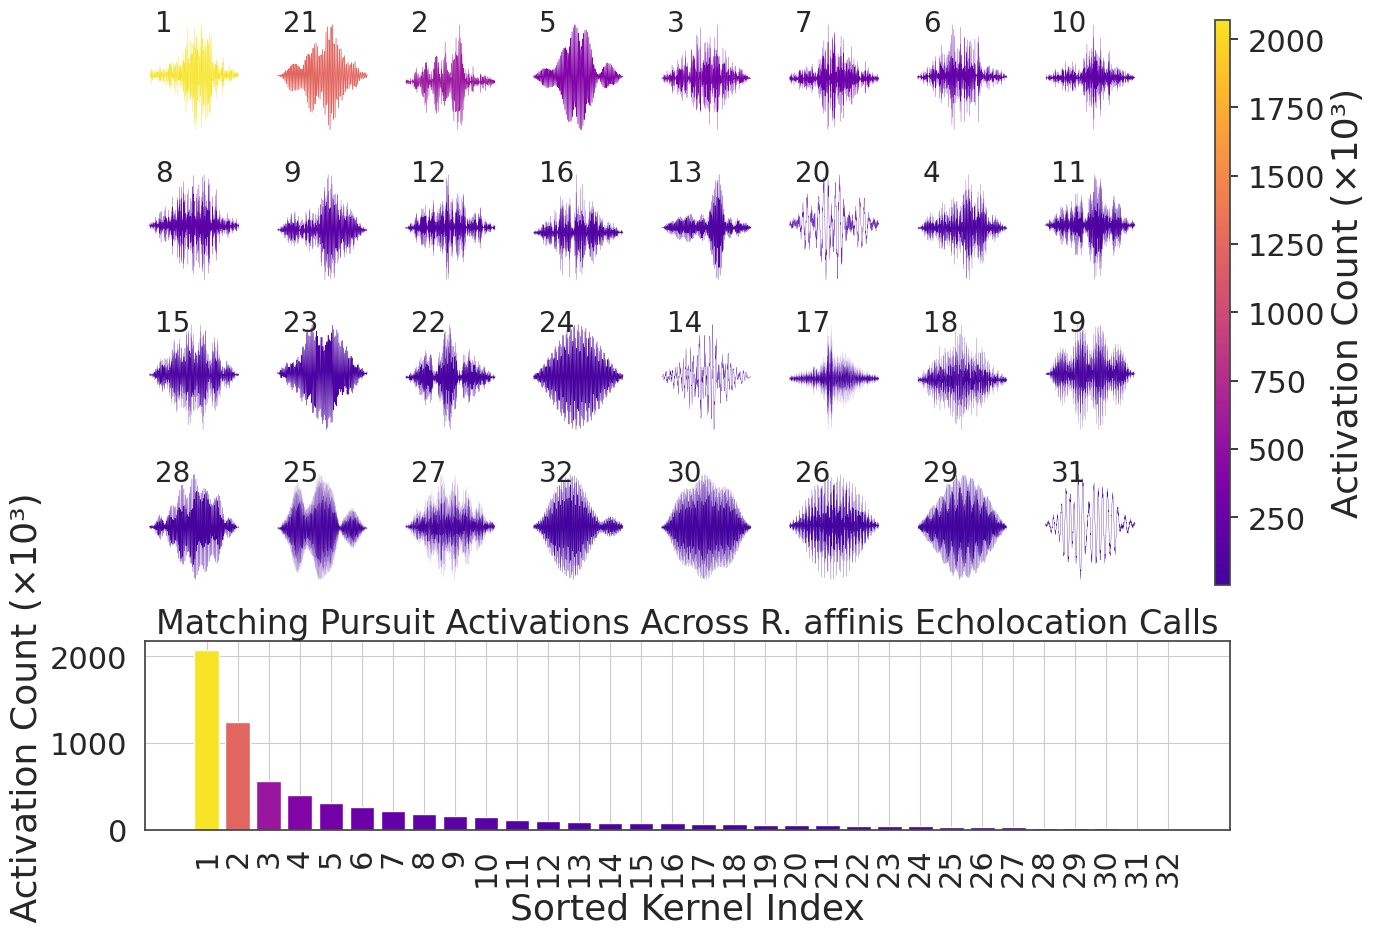

In [60]:
fig = plot_kernels_with_activation(sorted_dictionary_p, activation_counts_p, num_files=4778, ids=top70_based_ids)

In [15]:
fig.savefig("diagrams\kernels.pdf", bbox_inches='tight')


In [6]:
import numpy as np
from scipy.signal import spectrogram
from scipy.stats import entropy
from scipy.stats import skew
from scipy.signal import correlate

def normalized_cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-12)
    b = (b - np.mean(b)) / (np.std(b) + 1e-12)
    corr = correlate(a, b, mode='full')
    return np.max(corr) / len(a)

def compute_symmetry(kernel_data):
    reversed_data = kernel_data[::-1]
    k_norm = kernel_data / (np.linalg.norm(kernel_data) + 1e-12)
    r_norm = reversed_data / (np.linalg.norm(reversed_data) + 1e-12)
    symmetry_val = np.dot(k_norm, r_norm)
    return symmetry_val

def compute_90_percent_bandwidth(frequencies, power):
    power /= np.sum(power)  # Normalize
    cumulative = np.cumsum(power)
    lower_idx = np.searchsorted(cumulative, 0.05)
    upper_idx = np.searchsorted(cumulative, 0.95)
    return frequencies[upper_idx] - frequencies[lower_idx]

def analyze_kernel_characteristics(dictionary, fs=200000):
    durations = []
    peak_amps = []
    energies = []
    spectral_centroids = []
    bandwidths = []
    entropies = []
    sparsities = []
    symmetries = []
    skewnesses = []

    for kernel in dictionary:
        data = kernel.kernel
        durations.append(len(data))
        peak_amps.append(np.max(np.abs(data)))
        energies.append(np.sum(data ** 2))

        # Spectrogram-based frequency analysis
        f, t, Sxx = spectrogram(data, fs=fs, nperseg=min(256, len(data)))
        Sxx = Sxx + 1e-12  # Avoid log(0)
        power = np.sum(Sxx, axis=1)
        power /= np.sum(power)

        spectral_centroids.append(np.sum(f * power))
        bandwidths.append(compute_90_percent_bandwidth(f, power))

        norm_data = np.abs(data) / (np.sum(np.abs(data)) + 1e-12)
        entropies.append(entropy(norm_data))

        l1 = np.linalg.norm(data, 1)
        l2 = np.linalg.norm(data, 2)
        n = len(data)
        hoyer = (np.sqrt(n) - l1 / (l2 + 1e-12)) / (np.sqrt(n) - 1) if l2 != 0 else 0
        sparsities.append(hoyer)

        sym = compute_symmetry(data)
        symmetries.append(sym)

        skewness_val = skew(data)
        skewnesses.append(skewness_val)

    n_kernels = len(dictionary)
    sim_values = []
    for i in range(n_kernels):
        for j in range(i + 1, n_kernels):
            sim = normalized_cross_correlation(dictionary[i].kernel, dictionary[j].kernel)
            sim_values.append(sim)

    mean_similarity = np.mean(sim_values) if sim_values else 0

    return {
        "duration_mean": np.mean(durations),
        "peak_amp_mean": np.mean(peak_amps),
        "energy_mean": np.mean(energies),
        "spectral_centroid_mean": np.mean(spectral_centroids),
        "bandwidth_mean": np.mean(bandwidths),
        "entropy_mean": np.mean(entropies),
        "sparsity_mean": np.mean(sparsities),
        "symmetry_mean": np.mean(symmetries),
        "skewness_mean": np.mean(skewnesses),
        "mean_pairwise_similarity": mean_similarity,
        "individual_metrics": {
            "durations": durations,
            "peak_amps": peak_amps,
            "energies": energies,
            "spectral_centroids": spectral_centroids,
            "bandwidths": bandwidths,
            "entropies": entropies,
            "sparsities": sparsities,
            "symmetries": symmetries,
            "skewnesses": skewnesses,
            "pairwise_similarity_scores": sim_values
        }
    }

In [7]:
def print_kernel_characteristics(stats):
    """
    Pretty-print the summary statistics of learned kernel characteristics.

    Parameters:
        stats (dict): Output from analyze_kernel_characteristics().
    """
    print("=== Summary of Learned Kernel Characteristics ===\n")
    
    print(f"→ Average Duration (samples):          {stats['duration_mean']:.2f}")
    print(f"→ Average Peak Amplitude:              {stats['peak_amp_mean']:.4f}")
    print(f"→ Average Energy:                      {stats['energy_mean']:.4f}")
    print(f"→ Average Spectral Centroid (Hz):      {stats['spectral_centroid_mean']:.2f}")
    print(f"→ Average Bandwidth (Hz):              {stats['bandwidth_mean']:.2f}")
    print(f"→ Average Entropy:                     {stats['entropy_mean']:.4f}")
    print(f"→ Average Hoyer Sparsity:              {stats['sparsity_mean']:.4f}")
    print(f"→ Average Symmetry:                    {stats['symmetry_mean']:.4f}")
    print(f"→ Mean Skewness:                       {stats['skewness_mean']:.4f}")
    print(f"→ Mean Pairwise DTW Similarity:        {stats['mean_pairwise_similarity']:.4f}")

    print("\n(Distributions and example visualizations can be plotted using the 'individual_metrics' dictionary.)")


In [62]:
characteristics = analyze_kernel_characteristics(sorted_dictionary)
print_kernel_characteristics(characteristics)

# for i, sym in enumerate(characteristics['individual_metrics']['symmetries']):
#     print(f"Kernel {i}: Symmetry = {sym:.4f}")

# for i, sym in enumerate(characteristics['individual_metrics']['skewnesses']):
#     print(f"Kernel {i}: Skewness = {sym:.4f}")

spectral_centroids = characteristics['individual_metrics']['spectral_centroids']
bandwidths = characteristics['individual_metrics']['bandwidths']

skewnesses = characteristics['individual_metrics']['skewnesses']
durations = characteristics['individual_metrics']['durations']

mean_skew = np.mean(skewnesses)
std_skew = np.std(skewnesses)

print(f"Mean skewness: {mean_skew:.4f}")
print(f"Standard deviation of skewness: {std_skew:.4f}")

for i in range(len(spectral_centroids)):
    print(f"Kernel {i}: spectral centroid = {spectral_centroids[i]:.4f}")
    print(f"Kernel {i}: bandwidth = {bandwidths[i]:.4f}")
    print(f"Kernel {i}: duration = {durations[i]:.4f}")
    # print(f"Kernel {i}: symmetry = {symmetry[i]:.4f}")
    print()

=== Summary of Learned Kernel Characteristics ===

→ Average Duration (samples):          540.44
→ Average Peak Amplitude:              0.1543
→ Average Energy:                      1.0000
→ Average Spectral Centroid (Hz):      69798.20
→ Average Bandwidth (Hz):              13744.78
→ Average Entropy:                     5.7437
→ Average Hoyer Sparsity:              0.2947
→ Average Symmetry:                    0.0531
→ Mean Skewness:                       -0.0020
→ Mean Pairwise DTW Similarity:        0.0924

(Distributions and example visualizations can be plotted using the 'individual_metrics' dictionary.)
Mean skewness: -0.0020
Standard deviation of skewness: 0.0472
Kernel 0: spectral centroid = 72141.0259
Kernel 0: bandwidth = 781.2500
Kernel 0: duration = 290.0000

Kernel 1: spectral centroid = 72763.4672
Kernel 1: bandwidth = 14062.5000
Kernel 1: duration = 458.0000

Kernel 2: spectral centroid = 73774.0545
Kernel 2: bandwidth = 12500.0000
Kernel 2: duration = 707.0000

Kernel 

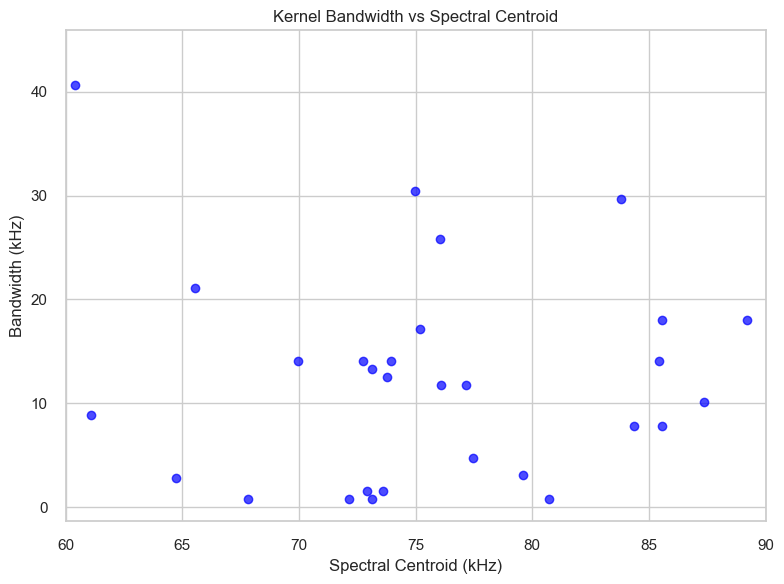

In [13]:
bandwidths_khz = np.array(characteristics["individual_metrics"]["bandwidths"]) / 1000  # Convert Hz to kHz
spectral_centroids = np.array(characteristics["individual_metrics"]["spectral_centroids"]) / 1000

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(spectral_centroids, bandwidths_khz, c='blue', alpha=0.7)
plt.xlabel('Spectral Centroid (kHz)')
plt.xlim(60, 90)
plt.ylabel('Bandwidth (kHz)')
plt.title('Kernel Bandwidth vs Spectral Centroid')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
def get_kernel_frequency(kernel, sr):
    """
    Estimate the spectral centroid (center of mass) of the kernel's frequency content.
    """
    freqs, psd = periodogram(kernel, fs=sr)
    psd_sum = np.sum(psd)
    if psd_sum == 0:
        return 0  # Avoid division by zero
    return np.sum(freqs * psd) / psd_sum


In [ ]:
def plot_sparse_coding_spike_map_kernels(waveform, sr, dictionary, indices, amps, time_idxs, 
                                 left=0.015, right=0.01, fontsize=16):
    plt.rcParams['font.family'] = 'Verdana'

    left_crop = int(sr * left)
    right_crop = -int(sr * right)
    
    waveform_cropped = waveform[left_crop:right_crop]
    reconstructed = np.zeros_like(waveform)

    for idx, amp, t in zip(indices, amps, time_idxs):
        k = dictionary[idx].kernel
        norm_k = np.linalg.norm(k)
        if norm_k > 0:
            k_normalized = k / norm_k
            adjusted_amp = amp * norm_k
        else:
            k_normalized = k
            adjusted_amp = amp

        t_start = t
        t_end = t + len(k_normalized)

        if t_start < 0:
            k_normalized = k_normalized[-t_start:]
            t_start = 0
        if t_end > len(reconstructed):
            k_normalized = k_normalized[:len(reconstructed) - t_start]

        reconstructed[t_start:t_start + len(k_normalized)] += adjusted_amp * k_normalized

    reconstructed_cropped = reconstructed[left_crop:right_crop]
    residual_cropped = waveform_cropped - reconstructed_cropped
    time_cropped = np.arange(len(waveform_cropped)) / sr

    valid_spikes = [(i, a, t) for i, a, t in zip(indices, amps, time_idxs) 
                    if left_crop <= t < (len(waveform) + right_crop)]

    if valid_spikes:
        indices_cropped, amps_cropped, time_idxs_cropped = zip(*valid_spikes)
    else:
        indices_cropped, amps_cropped, time_idxs_cropped = [], [], []

    spike_times_cropped = [(t - left_crop) / sr for t in time_idxs_cropped]

    max_amp = max(np.max(np.abs(waveform_cropped)),
                  np.max(np.abs(reconstructed_cropped)),
                  np.max(np.abs(residual_cropped)))

    mse = mean_squared_error(waveform_cropped, reconstructed_cropped)
    print(f"Residual MSE: {mse:.6e}")

    signal_power = np.sum(np.square(waveform_cropped))
    noise_power = np.sum(np.square(waveform_cropped - reconstructed_cropped))
    snr = float('inf') if noise_power == 0 else 10 * np.log10(signal_power / noise_power)
    print(f"Reconstruction SNR: {snr:.2f} dB")

    fig, axs = plt.subplots(4, 1, figsize=(8, 5),
                            gridspec_kw={'height_ratios': [5, 1, 1, 1]},
                            sharex=True)

    kernel_freqs = [get_kernel_frequency(k.kernel, sr) / 1000 for k in dictionary]  # now in kHz

    most_common_kernels = [k for k, _ in Counter(indices_cropped).most_common(20)]
    print(f"Number of distinct kernels in cropped indices: {len(set(indices_cropped))}")

    colors = ['deepskyblue', 'mediumspringgreen', 'turquoise', 'palegreen', 'greenyellow', 'yellow',
              'gold', 'orange', 'darkorange', 'orangered', 'tomato', 'crimson', 'coral', 'lightcoral',
              'hotpink', 'deeppink', 'fuchsia', 'darkorchid', 'darkviolet', 'blueviolet']

    spike_plot_data = []

    axs[2].plot(time_cropped, reconstructed_cropped, linewidth=0.1, alpha=0.5, color="black")
    axs[2].set_ylim([-max_amp, max_amp])
    axs[2].axis('off')
    axs[2].text(0, 1.1, "Reconstruction", transform=axs[2].transAxes, fontsize=fontsize, va='top', ha='left')

    for kernel_idx, color in zip(most_common_kernels, colors):
        kernel = dictionary[kernel_idx].kernel
        kernel_length = len(kernel)
        kernel_spike_indices = [idx for idx, i in enumerate(indices_cropped) if i == kernel_idx]
        if not kernel_spike_indices:
            continue

        for spike_idx in kernel_spike_indices:
            current_t = time_idxs_cropped[spike_idx]
            amp = amps_cropped[spike_idx]
            amp_scaled_value = (np.abs(amp) / np.max(np.abs(amps_cropped))) ** 2.5
            kernel_time = (np.arange(kernel_length) + (current_t - left_crop)) / sr
            scaled_kernel = amp * kernel
            axs[2].plot(kernel_time, scaled_kernel, linewidth=0.3, color=color, alpha=0.7)
            spike_time = (current_t - left_crop) / sr
            kernel_freq = kernel_freqs[kernel_idx]
            spike_plot_data.append({
                'time': spike_time,
                'freq': kernel_freq,
                'amp_scaled': amp_scaled_value,
                'color': color
            })

    axs[0].set_ylabel("Centroid (kHz)", fontsize=fontsize - 1)
    axs[0].set_xlabel("Time (s)", fontsize=fontsize - 2)
    axs[0].set_xlim([0, len(waveform_cropped) / sr])
    axs[0].tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,
                       labelbottom=True, labelleft=True, direction='in', labelsize=fontsize - 3)
    axs[0].grid(False)
    axs[0].set_ylim(bottom=65, top=90)  # in kHz

    max_kernel_idx = len(kernel_freqs) - 1
    unmatched_spikes = [
        (t, i, a) for i, t, a in zip(indices_cropped, time_idxs_cropped, amps_cropped)
        if (i not in most_common_kernels) and (0 <= i <= max_kernel_idx)
    ]

    for t, i, a in unmatched_spikes:
        spike_time = (t - left_crop) / sr
        freq = kernel_freqs[i]
        amp_scaled_value = (np.abs(a) / np.max(np.abs(amps_cropped))) ** 2.5
        s = 7 + 100 * amp_scaled_value
        alpha = 0.3 + 0.7 * amp_scaled_value
        axs[0].scatter(spike_time, freq, s=s, c='black', alpha=alpha, linewidths=0.3)

    for d in spike_plot_data:
        s = 7 + 100 * d['amp_scaled']
        a = 0.3 + 0.7 * d['amp_scaled']
        axs[0].scatter(d['time'], d['freq'], s=s, c=d['color'], alpha=a, linewidths=0.3, edgecolors=d['color'])

    axs[1].plot(time_cropped, waveform_cropped, linewidth=0.1, alpha=0.5, color="black")
    axs[1].set_ylim([-max_amp, max_amp])
    axs[1].axis('off')
    axs[1].text(0, 1, "Input", transform=axs[1].transAxes, fontsize=fontsize, va='top', ha='left')

    axs[3].plot(time_cropped, residual_cropped, linewidth=0.1, alpha=0.5, color="black")
    axs[3].set_ylim([-max_amp, max_amp])
    axs[3].axis('off')
    axs[3].set_xlabel("Time (s)", fontsize=fontsize - 2)
    axs[3].text(0, 0.98, "Residual", transform=axs[3].transAxes, fontsize=fontsize, va='top', ha='left')

    pos1 = axs[1].get_position()
    pos2 = axs[2].get_position()
    pos3 = axs[3].get_position()
    axs[1].set_position([pos1.x0, pos1.y0 - 0.05, pos1.width, pos1.height])
    axs[2].set_position([pos2.x0, pos2.y0 - 0.025, pos2.width, pos2.height])
    axs[3].set_position([pos3.x0, pos3.y0 + 0.035, pos3.width, pos3.height])

    plt.show()


In [777]:
from matplotlib.ticker import MaxNLocator

def plot_sparse_coding_spike_map(waveform, sr, dictionary, indices, amps, time_idxs, 
                                 left=0.015, right=0.01, fontsize=16):
    # plt.rcParams['font.family'] = 'Verdana'
    plt.rcParams.update({
        "axes.edgecolor": "#444444",
        "axes.linewidth": 1.1,
        "grid.color": "#cccccc",
        "grid.linewidth": 0.8,
        "legend.frameon": False,
        "mathtext.fontset": "cm",
        "font.family": "DejaVu Sans", 
    })

    left_crop = int(sr * left)
    right_crop = -int(sr * right)
    
    waveform_cropped = waveform[left_crop:right_crop]
    reconstructed = np.zeros_like(waveform)

    # Reconstruct waveform (no changes)
    for idx, amp, t in zip(indices, amps, time_idxs):
        k = dictionary[idx].kernel
        norm_k = np.linalg.norm(k)
        if norm_k > 0:
            k_normalized = k / norm_k
            adjusted_amp = amp * norm_k
        else:
            k_normalized = k
            adjusted_amp = amp

        t_start = t
        t_end = t + len(k_normalized)

        if t_start < 0:
            k_normalized = k_normalized[-t_start:]
            t_start = 0
        if t_end > len(reconstructed):
            k_normalized = k_normalized[:len(reconstructed) - t_start]

        reconstructed[t_start:t_start + len(k_normalized)] += adjusted_amp * k_normalized

    reconstructed_cropped = reconstructed[left_crop:right_crop]
    residual_cropped = waveform_cropped - reconstructed_cropped
    time_cropped = np.arange(len(waveform_cropped)) / sr

    valid_spikes = [(i, a, t) for i, a, t in zip(indices, amps, time_idxs) 
                    if left_crop <= t < (len(waveform) + right_crop)]

    if valid_spikes:
        indices_cropped, amps_cropped, time_idxs_cropped = zip(*valid_spikes)
    else:
        indices_cropped, amps_cropped, time_idxs_cropped = [], [], []

    spike_times_cropped = [(t - left_crop) / sr for t in time_idxs_cropped]

    max_amp = max(np.max(np.abs(waveform_cropped)),
                  np.max(np.abs(reconstructed_cropped)),
                  np.max(np.abs(residual_cropped)))

    mse = mean_squared_error(waveform_cropped, reconstructed_cropped)
    print(f"Residual MSE: {mse:.6e}")

    signal_power = np.sum(np.square(waveform_cropped))
    noise_power = np.sum(np.square(waveform_cropped - reconstructed_cropped))
    snr = float('inf') if noise_power == 0 else 10 * np.log10(signal_power / noise_power)
    print(f"Reconstruction SNR: {snr:.2f} dB")
    
    fig, axs = plt.subplots(4, 1, figsize=(8, 6),
                            gridspec_kw={'height_ratios': [10, 2, 2, 3]})

    # 1. Spike map (frequency vs time) - keep as before (no change)
    kernel_freqs = [get_kernel_frequency(k.kernel, sr) / 1000 for k in dictionary]  # kHz

    colors = ['deepskyblue', 'mediumspringgreen', 'turquoise', 'palegreen', 'greenyellow', 'yellow',
              'gold', 'orange', 'darkorange', 'orangered', 'tomato', 'crimson', 'coral', 'lightcoral',
              'hotpink', 'deeppink', 'fuchsia', 'darkorchid', 'darkviolet', 'blueviolet']

    # Prepare spike plot data without kernel plotting
    spike_plot_data = []

    # Get distinct kernels in cropped indices (for color mapping)
    most_common_kernels = [k for k, _ in Counter(indices_cropped).most_common(20)]
    print(f"Number of distinct kernels in cropped indices: {len(set(indices_cropped))}")

    axs[0].set_ylabel("Centroid Frequency (kHz)   ", fontsize=fontsize)
    axs[0].set_xlim([0, len(waveform_cropped) / sr])
    axs[0].tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,
                       labelbottom=True, labelleft=True, direction='in', labelsize=fontsize)
    axs[0].grid(False)
    axs[0].set_ylim(bottom=65, top=85)  # in kHz

    max_kernel_idx = len(kernel_freqs) - 1
    unmatched_spikes = [
        (t, i, a) for i, t, a in zip(indices_cropped, time_idxs_cropped, amps_cropped)
        if (i not in most_common_kernels) and (0 <= i <= max_kernel_idx)
    ]

    for t, i, a in unmatched_spikes:
        spike_time = (t - left_crop) / sr
        freq = kernel_freqs[i]
        amp_scaled_value = (np.abs(a) / np.max(np.abs(amps_cropped))) ** 2.5 if amps_cropped else 1
        s = 7 + 100 * amp_scaled_value
        alpha = 0.3 + 0.7 * amp_scaled_value
        axs[0].scatter(spike_time, freq, s=s, c='black', alpha=alpha, linewidths=0.3)

    for kernel_idx, color in zip(most_common_kernels, colors):
        kernel_freq = kernel_freqs[kernel_idx]
        for spike_idx, i in enumerate(indices_cropped):
            if i == kernel_idx:
                t = time_idxs_cropped[spike_idx]
                a = amps_cropped[spike_idx]
                spike_time = (t - left_crop) / sr
                amp_scaled_value = (np.abs(a) / np.max(np.abs(amps_cropped))) ** 2.5 if amps_cropped else 1
                s = 7 + 100 * amp_scaled_value
                alpha = 0.3 + 0.7 * amp_scaled_value
                axs[0].scatter(spike_time, kernel_freq, s=s, c=color, alpha=alpha, linewidths=0.3, edgecolors=color)

    # 2. Input waveform only
    axs[1].plot(time_cropped, waveform_cropped, linewidth=0.5, color="gray", alpha=0.8)
    axs[1].set_ylim([-max_amp, max_amp])
    axs[1].axis('off')
    axs[1].text(0, 1, "(a) Input", transform=axs[1].transAxes, fontsize=fontsize, va='top', ha='left')

    # 3. Input + Reconstruction overlay
    # axs[2].plot(time_cropped, waveform_cropped, linewidth=0.5, color="black", label='Input', alpha=0.5)
    axs[2].plot(time_cropped, reconstructed_cropped, linewidth=0.5, color="yellowgreen", label='Reconstruction', alpha=0.8)
    axs[2].set_ylim([-max_amp, max_amp])
    axs[2].axis('off')
    axs[2].text(0, 1.1, "(b) Reconstruction", transform=axs[2].transAxes, fontsize=fontsize, va='top', ha='left')
    # axs[2].legend(loc='upper right', fontsize=fontsize - 2)

    # Plot only two individual kernel activations
    for i, (kernel_idx, t, amp) in enumerate(zip(indices_cropped, time_idxs_cropped, amps_cropped)):
        if i == 0:
            kernel = dictionary[kernel_idx].kernel
            kernel_length = len(kernel)
            kernel_time = (np.arange(kernel_length) + (t - left_crop)) / sr
            scaled_kernel = amp * kernel
            amp_scaled_value = (np.abs(amp) / np.max(np.abs(amps_cropped))) ** 2.5
            color = 'deepskyblue'

            axs[2].plot(kernel_time, scaled_kernel, linewidth=0.3, color=color, alpha=0.9)
            spike_time = (t - left_crop) / sr
            kernel_freq = kernel_freqs[kernel_idx]
            spike_plot_data.append({
                'time': spike_time,
                'freq': kernel_freq,
                'amp_scaled': amp_scaled_value,
                'color': color
            })
        elif i == 26:
            kernel = dictionary[kernel_idx].kernel
            kernel_length = len(kernel)
            kernel_time = (np.arange(kernel_length) + (t - left_crop)) / sr
            scaled_kernel = amp * kernel
            amp_scaled_value = (np.abs(amp) / np.max(np.abs(amps_cropped))) ** 2.5
            color = 'orange'

            axs[2].plot(kernel_time, scaled_kernel, linewidth=0.3, color=color, alpha=0.9)
            spike_time = (t - left_crop) / sr
            kernel_freq = kernel_freqs[kernel_idx]
            spike_plot_data.append({
                'time': spike_time,
                'freq': kernel_freq,
                'amp_scaled': amp_scaled_value,
                'color': color
            })

    # 4. Residual energy in dB: 20 * log10(|residual|)
    residual_abs = np.abs(residual_cropped)
    residual_db = 20 * np.log10(np.maximum(residual_abs, 1e-12))
    mean_residual_db = np.mean(residual_db)

    axs[3].plot(time_cropped, residual_db, color='coral', linewidth=0.7)
    axs[3].text(0, 1.29, "(c) Residual Energy (dB): 20·log₁₀(|Residual|)", transform=axs[3].transAxes, fontsize=fontsize, va='top', ha='left')

    # axs[3].set_ylabel("Residual Energy (dB) \n20·log₁₀(|Residual|)", fontsize=fontsize)
    axs[3].set_xlabel("Time (s)", fontsize=fontsize)
    axs[3].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False,
                       labelsize=fontsize - 3, labelbottom=False, direction='in')
    axs[3].grid(False)
    axs[3].set_ylim([residual_db.min() - 5, residual_db.max() + 5])
    axs[3].yaxis.set_major_locator(MaxNLocator(nbins=5, prune=None))
    axs[3].text(0.04, 0.15, f"Mean Residual Energy: {mean_residual_db:.2f} dB", transform=axs[3].transAxes,
            fontsize=fontsize - 3, ha='left', va='bottom',  color='#444444')

    pos1 = axs[1].get_position()
    pos2 = axs[2].get_position()
    pos3 = axs[3].get_position()
    axs[1].set_position([pos1.x0, pos1.y0 - 0.05, pos1.width, pos1.height])
    axs[2].set_position([pos2.x0, pos2.y0 - 0.035, pos2.width, pos2.height])
    axs[3].set_position([pos3.x0, pos3.y0 - 0.035, pos3.width, pos3.height])

    # plt.tight_layout()
    plt.show()
    return fig


In [22]:
# Load dictionary
dictionary = mp.create_dictionary_from_JLD2("kernels_high_400_10000.jld2")

# Choose or set a WAV file
filename = random.choice([
    f for f in os.listdir("high_rhinolophus_affinis_segments") if f.endswith('.wav')
])
full_path = os.path.join("high_rhinolophus_affinis_segments", filename)
print(filename)

# Load the corresponding waveform
waveform, sr = sf.read(full_path)
waveform = waveform / np.max(np.abs(waveform))

A002166_MFPRYJQSCD_call_11_0.96-1.01s.wav


In [23]:
# Load activation data from CSV
csv_path = "RA_activations.csv"
df = pd.read_csv(csv_path)
print(df['filename'].head(10).tolist())
file_activations = df[df['filename'] == filename]

['A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav', 'A000325_PSWGVNESEJ_call_10_2.27-2.38s.wav']


In [ ]:
def extract_mp_components(file_activations, top_n=None):
    if top_n is not None:
        file_activations = file_activations.reindex(
            file_activations['amplitude'].abs().sort_values(ascending=False).index
        ).head(top_n)
    # print(residuals)
    indices = (file_activations['kernel'].astype(int) - 1).tolist()
    # print(indices)
    amps = file_activations['amplitude'].tolist()
    time_idxs = (file_activations['time'].astype(int) - 1).tolist()
    return indices, amps, time_idxs

Residual MSE: 1.665338e-03
Reconstruction SNR: 17.93 dB
Number of distinct kernels in cropped indices: 9


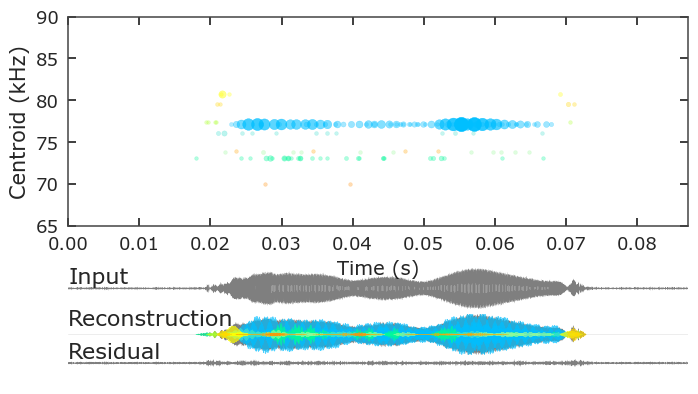

In [497]:
indices, amps, time_idxs = extract_mp_components(file_activations, 150)
plot_sparse_coding_spike_map_kernels(
    waveform, sr, dictionary, indices, amps, time_idxs,
    left=0.001, right=0.001
)

In [755]:
# Load dictionary
dictionary = mp.create_dictionary_from_JLD2("kernels_high_400_10000.jld2")
full_path = os.path.join("high_rhinolophus_affinis_segments", "A001704_AUAURBYMPI_call_19_3.88-3.97s.wav")
waveform, sr = sf.read(full_path)
waveform = waveform / np.max(np.abs(waveform))
csv_path = "RA_activations.csv"
df = pd.read_csv(csv_path)
file_activations = df[df['filename'] == "A001704_AUAURBYMPI_call_19_3.88-3.97s.wav"]


Residual MSE: 1.214737e-03
Reconstruction SNR: 20.62 dB
Number of distinct kernels in cropped indices: 13


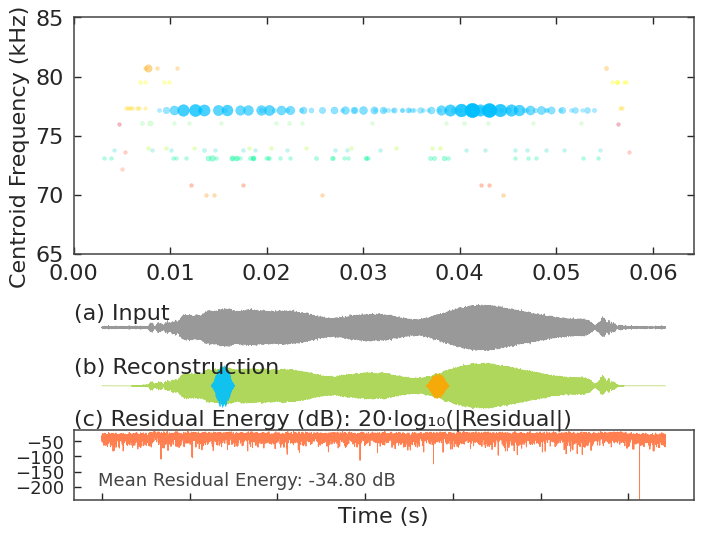

In [943]:
indices, amps, time_idxs = extract_mp_components(file_activations, 200)
# Plot
fig = plot_sparse_coding_spike_map(
    waveform, sr, dictionary, indices, amps, time_idxs,
    left=0.015, right=0.01
)

In [550]:
fig.savefig("diagrams\spikes.pdf", bbox_inches='tight')


In [26]:
def plot_spectrogram(y , sr, nperseg=1024):
    print(len(y) * 1.0 / sr)
    noverlap = int(nperseg * 0.75)  # 75% overlap
    print(sr)
    
    f, t, Sxx = spectrogram(y, fs=sr, nperseg=nperseg, noverlap=noverlap)
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 8))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto', cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.xlim(0, len(y)/sr) 
    
    plt.colorbar(label='Spectral Power [dB]')
    plt.title('Spectrogram of Rhinolophus Affinis Echolocation Call')
    plt.show()

In [27]:
def estimate_bitrate(activations, K, fs, T, amplitude_bits=8, time_quantization='sample'):
    n_atoms = len(activations)

    # Bits for kernel index
    kernel_bits = int(np.ceil(np.log2(K)))

    # Bits for time position
    if time_quantization == 'sample':
        n_samples = int(T * fs)
        time_bits = int(np.ceil(np.log2(n_samples)))
    elif isinstance(time_quantization, int):
        # e.g. 1000 bins per second (1 ms resolution)
        time_bins = int(T * time_quantization)
        time_bits = int(np.ceil(np.log2(time_bins)))
    else:
        raise ValueError("Invalid time_quantization value")

    # Bits per atom
    bits_per_atom = kernel_bits + time_bits + amplitude_bits

    # Total bitrate
    total_bits = n_atoms * bits_per_atom
    kbitrate = total_bits / T / 1000

    return kbitrate

In [28]:
def estimate_snr(original, residual):
    original = np.asarray(original)
    residual = np.asarray(residual)
    
    # Ensure same shape
    if original.shape != residual.shape:
        raise ValueError("original and residual must have the same shape.")
    
    signal_power = np.sum(original ** 2)
    noise_power = np.sum(residual ** 2)
    
    if noise_power == 0:
        return float('inf')  # Perfect reconstruction
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db


In [29]:
def reconstruct_and_residual(waveform, dictionary, indices, amps, time_idxs):
    reconstructed = np.zeros_like(waveform)

    for idx, amp, t in zip(indices, amps, time_idxs):
        k = dictionary[idx].kernel
        norm_k = np.linalg.norm(k)

        if norm_k > 0:
            k_normalized = k / norm_k
            adjusted_amp = amp * norm_k
        else:
            k_normalized = k
            adjusted_amp = amp

        t_start = t
        t_end = t + len(k_normalized)

        # Handle boundaries
        if t_start < 0:
            k_normalized = k_normalized[-t_start:]
            t_start = 0
        if t_end > len(reconstructed):
            k_normalized = k_normalized[:len(reconstructed) - t_start]

        reconstructed[t_start:t_start + len(k_normalized)] += adjusted_amp * k_normalized

    residual = waveform - reconstructed
    return reconstructed, residual


In [30]:
indices, amps, time_idxs = extract_mp_components(file_activations, 1000)

# Combine into (kernel_index, time_position, amplitude) tuples
activations = list(zip(indices, time_idxs, amps))

# Parameters
K = max(indices) + 1  # or use len(dictionary) if you know full size
fs = 200000            # Adjust to your actual sampling rate
T = len(waveform) / fs  # Signal duration in seconds
amplitude_bits = 64       # Full double-precision float

# Estimate bitrate
bitrate = estimate_bitrate(
    activations, K, fs, T,
    amplitude_bits=amplitude_bits,
    time_quantization='sample'  # or use int (e.g. 1000 for 1ms resolution)
)

reconstructed_signal, residual_signal = reconstruct_and_residual(waveform, dictionary, indices, amps, time_idxs)
snr = estimate_snr(waveform, residual_signal) 
print(f"SNR: {snr:.2f} dB")
print(f"Estimated kbitrate: {bitrate:.2f} kbits/s")

SNR: 26.92 dB
Estimated kbitrate: 941.44 kbits/s


In [32]:
# Set a random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Load and index activation CSV
csv_path = "RA_activations.csv"
df = pd.read_csv(csv_path)
df = df.set_index('filename')

In [33]:
# Directory containing the .wav files
wav_dir = "high_rhinolophus_affinis_segments"

# Helper to extract the A-number (as integer)
def extract_ano(filename):
    match = re.match(r"A(\d+)_", filename)
    return int(match.group(1)) if match else None

# Filter and shuffle valid files (A-number ≤ 4777 and has activation data)
all_wav_files = [
    f for f in os.listdir(wav_dir)
    if f.endswith('.wav') and (extract_ano(f) is not None and extract_ano(f) <= 4777)
]
random.shuffle(all_wav_files)
selected_files = all_wav_files[:1000]
print(f"Selected {len(selected_files)} files.")

Selected 1000 files.


In [318]:
# Load waveforms and activations
waveforms = []
activations_list = []

for filename in tqdm(selected_files):
    full_path = os.path.join(wav_dir, filename)
    waveform, sr = sf.read(full_path, dtype='float32')  # faster and sufficient precision

    if waveform.ndim > 1:
        waveform = waveform.mean(axis=1)  # mix stereo to mono if needed

    max_val = np.max(np.abs(waveform))
    if max_val > 0:
        waveform = waveform / max_val

    waveforms.append(waveform)
    activations_list.append(df.loc[filename])

100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


In [232]:
def fourier_encode_signal(waveform, n_coeffs):
    """Keep n_coeffs largest-magnitude FFT coefficients and zero out the rest."""
    fft_coeffs = np.fft.fft(waveform)
    magnitude = np.abs(fft_coeffs)

    # Find indices of largest-magnitude coefficients
    largest_indices = np.argsort(magnitude)[-n_coeffs:]

    # Create sparse FFT
    sparse_fft = np.zeros_like(fft_coeffs, dtype=np.complex128)
    sparse_fft[largest_indices] = fft_coeffs[largest_indices]

    # Inverse FFT to reconstruct the signal
    reconstructed = np.fft.ifft(sparse_fft).real

    return reconstructed, sparse_fft

In [233]:
def estimate_fourier_bitrate(n_coeffs, duration_sec, bits_per_coeff=64):
    total_bits = n_coeffs * bits_per_coeff * 2  # 64 bits for real and imag parts
    bitrate_kbps = (total_bits / duration_sec) / 1000.0
    return bitrate_kbps


In [234]:
def estimate_fourier_snr(original, reconstructed):
    """Compute SNR in dB for Fourier-reconstructed signal."""
    noise = original - reconstructed
    signal_power = np.mean(original ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
    return snr


In [235]:
def wavelet_encode_signal(waveform, wavelet='db4', level=None, n_coeffs=100):
    # Wavelet decomposition
    coeffs = pywt.wavedec(waveform, wavelet=wavelet, level=level)
    # Flatten coefficients into a single array for sorting
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

    # Find indices of largest coefficients by magnitude
    abs_coeff = np.abs(coeff_arr)
    largest_indices = np.argsort(abs_coeff)[-n_coeffs:]

    # Zero out small coefficients
    sparse_coeff_arr = np.zeros_like(coeff_arr)
    sparse_coeff_arr[largest_indices] = coeff_arr[largest_indices]

    # Convert back to list of coeff arrays
    sparse_coeffs = pywt.array_to_coeffs(sparse_coeff_arr, coeff_slices, output_format='wavedec')

    # Reconstruct signal
    reconstructed = pywt.waverec(sparse_coeffs, wavelet=wavelet)

    # Truncate to original length if needed
    reconstructed = reconstructed[:len(waveform)]

    return reconstructed, sparse_coeff_arr

def estimate_wavelet_bitrate(n_coeffs, duration_sec, bits_per_coeff=64):
    total_bits = n_coeffs * bits_per_coeff
    bitrate_kbps = (total_bits / duration_sec) / 1000.0
    return bitrate_kbps

def estimate_wavelet_snr(original, reconstructed):
    noise = original - reconstructed
    signal_power = np.mean(original ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
    return snr


In [236]:
def compare_fourier_mp_wavelet_compression(
    waveforms,
    activations_list,
    dictionary,
    fs=200000,
    atom_counts=[50, 100, 200, 400, 800, 1200],
    coeff_counts=[50, 100, 200, 400, 800, 1200],
    wavelet_coeff_counts=[50, 100, 200, 400, 800, 1200],
    bits_per_coeff=64,
    amplitude_bits=64,
    time_quantization='sample',
    wavelet_name='db4',
):
    # Initialize MP
    mp_bitrates = [0]
    mp_snrs = [0]
    mp_bitrate_stds = [0]
    mp_snr_stds = [0]

    for n_atoms in atom_counts:
        snrs = []
        bitrates = []

        for waveform, file_activations in zip(waveforms, activations_list):
            indices, amps, time_idxs = extract_mp_components(file_activations, n_atoms)
            activations = list(zip(indices, time_idxs, amps))
            K = max(indices) + 1 if indices else 1
            T = len(waveform) / fs

            bitrate = estimate_bitrate(
                activations, K, fs, T,
                amplitude_bits=amplitude_bits,
                time_quantization=time_quantization
            )

            reconstructed, residual = reconstruct_and_residual(waveform, dictionary, indices, amps, time_idxs)
            snr = estimate_snr(waveform, residual)

            snrs.append(snr)
            bitrates.append(bitrate)

        mp_snrs.append(np.mean(snrs))
        mp_bitrates.append(np.mean(bitrates))
        mp_snr_stds.append(np.std(snrs))
        mp_bitrate_stds.append(np.std(bitrates))

        print(f"[MP] Atoms: {n_atoms}, Avg SNR: {mp_snrs[-1]:.2f} dB, Avg Bitrate: {mp_bitrates[-1]:.2f} kbit/s")

    # Fourier
    fourier_bitrates = [0]
    fourier_snrs = [0]
    fourier_bitrate_stds = [0]
    fourier_snr_stds = [0]

    for n_coeffs in coeff_counts:
        snrs = []
        bitrates = []

        for waveform in waveforms:
            waveform = waveform / np.max(np.abs(waveform))
            duration_sec = len(waveform) / fs

            reconstructed, _ = fourier_encode_signal(waveform, n_coeffs)
            snr = estimate_fourier_snr(waveform, reconstructed)
            bitrate = estimate_fourier_bitrate(n_coeffs, duration_sec, bits_per_coeff)

            snrs.append(snr)
            bitrates.append(bitrate)

        fourier_snrs.append(np.mean(snrs))
        fourier_bitrates.append(np.mean(bitrates))
        fourier_snr_stds.append(np.std(snrs))
        fourier_bitrate_stds.append(np.std(bitrates))

        print(f"[Fourier] Coeffs: {n_coeffs}, Avg SNR: {fourier_snrs[-1]:.2f} dB, Avg Bitrate: {fourier_bitrates[-1]:.2f} kbit/s")

    # Wavelet
    wavelet_bitrates = [0]
    wavelet_snrs = [0]
    wavelet_bitrate_stds = [0]
    wavelet_snr_stds = [0]

    for n_coeffs in wavelet_coeff_counts:
        snrs = []
        bitrates = []

        for waveform in waveforms:
            waveform = waveform / np.max(np.abs(waveform))
            duration_sec = len(waveform) / fs

            reconstructed, _ = wavelet_encode_signal(waveform, wavelet=wavelet_name, n_coeffs=n_coeffs)
            snr = estimate_wavelet_snr(waveform, reconstructed)
            bitrate = estimate_wavelet_bitrate(n_coeffs, duration_sec, bits_per_coeff)

            snrs.append(snr)
            bitrates.append(bitrate)

        wavelet_snrs.append(np.mean(snrs))
        wavelet_bitrates.append(np.mean(bitrates))
        wavelet_snr_stds.append(np.std(snrs))
        wavelet_bitrate_stds.append(np.std(bitrates))

        print(f"[Wavelet] Coeffs: {n_coeffs}, Avg SNR: {wavelet_snrs[-1]:.2f} dB, Avg Bitrate: {wavelet_bitrates[-1]:.2f} kbit/s")

    return (
        (mp_bitrates, mp_snrs, mp_bitrate_stds, mp_snr_stds),
        (fourier_bitrates, fourier_snrs, fourier_bitrate_stds, fourier_snr_stds),
        (wavelet_bitrates, wavelet_snrs, wavelet_bitrate_stds, wavelet_snr_stds)
    )


In [551]:
# Set a random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Load and index activation CSV
csv_path = "RP_activations_res.csv"
df = pd.read_csv(csv_path)
df = df.set_index('filename')
# Directory containing the .wav files
wav_dir = "high_rhinolophus_pearsonii_segments"

# Helper to extract the A-number (as integer)
def extract_ano(filename):
    match = re.match(r"A(\d+)_", filename)
    return int(match.group(1)) if match else None

# Filter and shuffle valid files (A-number ≤ 4777 and has activation data)
all_wav_files_p = [
    f for f in os.listdir(wav_dir)
    if f.endswith('.wav') and (extract_ano(f) is not None and extract_ano(f) <= 5625)
]
random.shuffle(all_wav_files_p)
selected_files_p = all_wav_files_p[:1000]
print(f"Selected {len(selected_files_p)} files.")
# Load waveforms and activations
waveforms_p = []
activations_list_p = []

for filename in tqdm(selected_files_p):
    full_path = os.path.join(wav_dir, filename)
    waveform, sr = sf.read(full_path, dtype='float32')  # faster and sufficient precision

    if waveform.ndim > 1:
        waveform = waveform.mean(axis=1)  # mix stereo to mono if needed

    max_val = np.max(np.abs(waveform))
    if max_val > 0:
        waveform = waveform / max_val

    waveforms_p.append(waveform)
    activations_list_p.append(df.loc[filename])

Selected 1000 files.


100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s]


In [237]:
# Run comparison for R. affinis
(
  (mp_bitrates_aff, mp_snrs_aff, mp_bitrate_stds_aff, mp_snr_stds_aff),
  (fourier_bitrates_aff, fourier_snrs_aff, fourier_bitrate_stds_aff, fourier_snr_stds_aff),
  (wavelet_bitrates_aff, wavelet_snrs_aff, wavelet_bitrate_stds_aff, wavelet_snr_stds_aff)
) = compare_fourier_mp_wavelet_compression(
    waveforms,
    activations_list,
    dictionary,
    fs=200000,
    atom_counts = [10, 50, 100, 200, 400, 800, 1600, 2400],
    coeff_counts = [10, 50, 100, 200, 400, 800, 1600, 2100],
    wavelet_coeff_counts = [50, 100, 200, 400, 800, 1600, 2600, 4200],
    bits_per_coeff=64,
    amplitude_bits=64,
    time_quantization='sample',
    wavelet_name='db4'
)


[MP] Atoms: 10, Avg SNR: 2.43 dB, Avg Bitrate: 10.15 kbit/s
[MP] Atoms: 50, Avg SNR: 8.99 dB, Avg Bitrate: 51.44 kbit/s
[MP] Atoms: 100, Avg SNR: 13.80 dB, Avg Bitrate: 103.03 kbit/s
[MP] Atoms: 200, Avg SNR: 19.21 dB, Avg Bitrate: 206.18 kbit/s
[MP] Atoms: 400, Avg SNR: 23.59 dB, Avg Bitrate: 412.40 kbit/s
[MP] Atoms: 800, Avg SNR: 26.99 dB, Avg Bitrate: 814.32 kbit/s
[MP] Atoms: 1600, Avg SNR: 29.80 dB, Avg Bitrate: 1426.79 kbit/s
[MP] Atoms: 2400, Avg SNR: 30.62 dB, Avg Bitrate: 1635.92 kbit/s
[Fourier] Coeffs: 10, Avg SNR: 4.60 dB, Avg Bitrate: 15.83 kbit/s
[Fourier] Coeffs: 50, Avg SNR: 10.43 dB, Avg Bitrate: 79.17 kbit/s
[Fourier] Coeffs: 100, Avg SNR: 13.13 dB, Avg Bitrate: 158.34 kbit/s
[Fourier] Coeffs: 200, Avg SNR: 15.78 dB, Avg Bitrate: 316.67 kbit/s
[Fourier] Coeffs: 400, Avg SNR: 18.41 dB, Avg Bitrate: 633.35 kbit/s
[Fourier] Coeffs: 800, Avg SNR: 21.72 dB, Avg Bitrate: 1266.70 kbit/s
[Fourier] Coeffs: 1600, Avg SNR: 27.46 dB, Avg Bitrate: 2533.39 kbit/s
[Fourier] Coeffs:

In [229]:
# Run comparison for R. pearsonii
(
  (mp_bitrates_pea, mp_snrs_pea, mp_bitrate_stds_pea, mp_snr_stds_pea),
  (fourier_bitrates_pea, fourier_snrs_pea, fourier_bitrate_stds_pea, fourier_snr_stds_pea),
  (wavelet_bitrates_pea, wavelet_snrs_pea, wavelet_bitrate_stds_pea, wavelet_snr_stds_pea)
) = compare_fourier_mp_wavelet_compression(
    waveforms_p,
    activations_list_p,
    dictionary,
    fs=200000,
    atom_counts = [10, 50, 100, 200, 400, 800, 1600, 2400, 10000],
    coeff_counts = [10, 50, 100, 200, 400, 800, 1600, 2100],
    wavelet_coeff_counts = [50, 100, 200, 400, 800, 1600, 2600, 4200],
    bits_per_coeff=64,
    amplitude_bits=64,
    time_quantization='sample',
    wavelet_name='db4'
)

NameError: name 'compare_fourier_mp_wavelet_compression' is not defined

0: 0.6955567007395863
1: 0.42221704134338506
2: 0.793086002615224
3: 0.9883217427071741
4: 0.32978314360453076
5: 0.3893020600206487


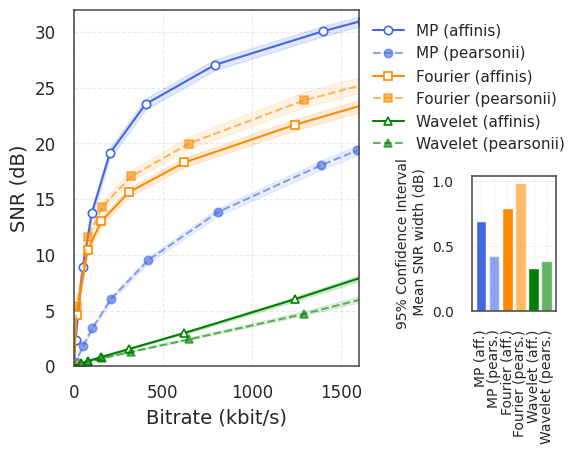

In [530]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 4.5))

def plot_method(x_aff, y_aff, y_std_aff,
                x_pea, y_pea, y_std_pea,
                label_base, color, marker):
    
    ci_multiplier = 1.96 / np.sqrt(1000)  # N = 1000 samples
    
    # Calculate CIs
    lower_aff = [y - ci_multiplier * s for y, s in zip(y_aff, y_std_aff)]
    upper_aff = [y + ci_multiplier * s for y, s in zip(y_aff, y_std_aff)]
    lower_pea = [y - ci_multiplier * s for y, s in zip(y_pea, y_std_pea)]
    upper_pea = [y + ci_multiplier * s for y, s in zip(y_pea, y_std_pea)]
    
    # Plot lines and CI areas
    plt.plot(x_aff, y_aff, marker=marker, linestyle='-', color=color,
             label=f'{label_base} (affinis)', linewidth=1.5, markersize=6,
             markerfacecolor='white', markeredgewidth=1.2, markeredgecolor=color)
    plt.fill_between(x_aff, lower_aff, upper_aff, color=color, alpha=0.15)

    plt.plot(x_pea, y_pea, marker=marker, linestyle='--', color=color,
             label=f'{label_base} (pearsonii)', linewidth=1.5, markersize=6,
             markerfacecolor=color, markeredgewidth=1.2, alpha=0.6)
    plt.fill_between(x_pea, lower_pea, upper_pea, color=color, alpha=0.1)
    
    # Return mean CI widths for affinis and pearsonii
    ci_widths_aff = [u - l for u, l in zip(upper_aff, lower_aff)]
    ci_widths_pea = [u - l for u, l in zip(upper_pea, lower_pea)]
    return np.mean(ci_widths_aff), np.mean(ci_widths_pea)


# Compute mean CI widths per group for the bar chart
ci_means = {}

ci_means['MP_aff'] = None
ci_means['MP_pea'] = None
ci_means['Fourier_aff'] = None
ci_means['Fourier_pea'] = None
ci_means['Wavelet_aff'] = None
ci_means['Wavelet_pea'] = None

ci_means['MP_aff'], ci_means['MP_pea'] = plot_method(
    mp_bitrates_aff, mp_snrs_aff, mp_snr_stds_aff,
    mp_bitrates_pea, mp_snrs_pea, mp_snr_stds_pea,
    'MP', 'royalblue', 'o'
)

ci_means['Fourier_aff'], ci_means['Fourier_pea'] = plot_method(
    fourier_bitrates_aff, fourier_snrs_aff, fourier_snr_stds_aff,
    fourier_bitrates_pea, fourier_snrs_pea, fourier_snr_stds_pea,
    'Fourier', 'darkorange', 's'
)

ci_means['Wavelet_aff'], ci_means['Wavelet_pea'] = plot_method(
    wavelet_bitrates_aff, wavelet_snrs_aff, wavelet_snr_stds_aff,
    wavelet_bitrates_pea, wavelet_snrs_pea, wavelet_snr_stds_pea,
    'Wavelet', 'green', '^'
)

plt.rcParams.update({
        "axes.edgecolor": "#444444",
        "axes.linewidth": 1.1,
        "grid.color": "#cccccc",
        "grid.linewidth": 0.8,
        "legend.frameon": False,
        "mathtext.fontset": "cm",
        "font.family": "DejaVu Sans", 
    })

plt.xlabel("Bitrate (kbit/s)", fontsize=14)
plt.ylabel("SNR (dB)", fontsize=14)
plt.xlim(0, 1600)
plt.ylim(0, 32)
plt.grid(True, linestyle='--', alpha=0.4)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.tick_params(labelsize=12)


# Bar chart inset for mean CI widths per representation/species
ax_bar = plt.gcf().add_axes([0.683, 0.29, 0.12, 0.3])  # right and below legend

labels = [
    'MP (aff.)', 'MP (pears.)',
    'Fourier (aff.)', 'Fourier (pears.)',
    'Wavelet (aff.)', 'Wavelet (pears.)'
]
values = [ci_means[label_key] for label_key in ['MP_aff', 'MP_pea', 'Fourier_aff', 'Fourier_pea', 'Wavelet_aff', 'Wavelet_pea']]

# Bar colors matching main plot colors
colors_map = {
    'MP_aff': 'royalblue',
    'MP_pea': 'royalblue',
    'Fourier_aff': 'darkorange',
    'Fourier_pea': 'darkorange',
    'Wavelet_aff': 'green',
    'Wavelet_pea': 'green'
}

bar_colors = [colors_map[label_key] for label_key in ['MP_aff', 'MP_pea', 'Fourier_aff', 'Fourier_pea', 'Wavelet_aff', 'Wavelet_pea']]

alphas = [1 if 'aff' in label_key else 0.6 for label_key in ['MP_aff', 'MP_pea', 'Fourier_aff', 'Fourier_pea', 'Wavelet_aff', 'Wavelet_pea']]

for i, (val, color, alpha) in enumerate(zip(values, bar_colors, alphas)):
    ax_bar.bar(i, val, color=color, alpha=alpha)
    print(f"{i}: {val}")

ax_bar.set_xticks(range(len(labels)))
ax_bar.set_xticklabels(labels, rotation=90, fontsize=10)  # rotation 0 for neatness, adjust fontsize
ax_bar.set_ylabel("95% Confidence Interval\n Mean SNR width (dB)", fontsize=10)
ax_bar.tick_params(axis='y', labelsize=10)
ax_bar.grid(True, linestyle='--', alpha=0.3)


plt.show()
fig.savefig("diagrams\efficiency.pdf", bbox_inches='tight')


In [579]:
def project_umap(data):
	reducer = umap.UMAP(random_state=42)
	embedding = reducer.fit_transform(data)
	return embedding

In [580]:
def cluster_with_kmeans(data, n_clusters = 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels

In [581]:
def plot_clustered(embedding, clusters, type="UMAP"):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Unique clusters for palette
    unique_clusters = np.unique(clusters)
    palette = sns.color_palette("hsv", len(unique_clusters))

    # Plot on the Axes object without legend
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=clusters,
        palette=palette,
        s=2,
        ax=ax,
        edgecolor='none',
        legend=False
    )

    ax.set_title(f"{type} Projection of Kernel Activation Counts Colored by K-Means Clusters")
    ax.set_xlabel(f"{type} Dimension 1")
    ax.set_ylabel(f"{type} Dimension 2")
    ax.grid(False)
    plt.tight_layout()
    plt.show()


In [582]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering_metrics(data, cluster_range=range(2, 40), silhouette_detail_k=None):
    silhouette_scores = []
    calinski_scores = []
    davies_scores = []
    all_labels = {}

    # Run clustering and compute metrics
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        labels = kmeans.labels_

        sil_avg = silhouette_score(data, labels)
        silhouette_scores.append(sil_avg)
        calinski_scores.append(calinski_harabasz_score(data, labels))
        davies_scores.append(davies_bouldin_score(data, labels))

        all_labels[k] = {
            'labels': labels,
            'samples': silhouette_samples(data, labels)
        }

    best_k_sil = cluster_range[np.argmax(silhouette_scores)]
    best_k_cal = cluster_range[np.argmax(calinski_scores)]
    best_k_dav = cluster_range[np.argmin(davies_scores)]

    if silhouette_detail_k is None:
        silhouette_detail_k = best_k_sil

    labels = all_labels[silhouette_detail_k]['labels']
    silhouette_vals = all_labels[silhouette_detail_k]['samples']
    k = silhouette_detail_k

    # Your vibrant color palette:
    cluster_colors = ['deepskyblue', 'mediumspringgreen', 'turquoise', 'palegreen', 'greenyellow',
                      'yellow', 'gold', 'orange', 'darkorange', 'orangered', 'tomato', 'crimson',
                      'coral', 'lightcoral', 'hotpink', 'deeppink', 'fuchsia', 'darkorchid',
                      'darkviolet', 'blueviolet']

    # Setup plot style for professional polished look
    sns.set_style("whitegrid")    
    sns.set_context("paper", font_scale=1.2)
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Georgia", "Palatino"],
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.edgecolor": "#444444",
        "axes.linewidth": 1.1,
        "grid.color": "#cccccc",
        "grid.linewidth": 0.8,
        "legend.frameon": False
    })

    fig, axs = plt.subplots(4, 1, figsize=(11, 18), gridspec_kw={'height_ratios': [1,1,1,1.6]}, constrained_layout=True)

    # 1) Silhouette Score plot
    axs[0].plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='deepskyblue', linewidth=2, markersize=7)
    axs[0].axvline(best_k_sil, linestyle='--', color='deepskyblue', alpha=0.5)
    axs[0].set_ylabel('Silhouette Score')
    axs[0].set_xlim(min(cluster_range), max(cluster_range))
    axs[0].grid(True, linestyle=':', alpha=0.7)
    axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # 2) Calinski-Harabasz Index plot
    axs[1].plot(cluster_range, calinski_scores, marker='s', linestyle='-', color='mediumspringgreen', linewidth=2, markersize=7)
    axs[1].axvline(best_k_cal, linestyle='--', color='mediumspringgreen', alpha=0.5)
    axs[1].set_ylabel('Calinski-Harabasz Index')
    axs[1].set_xlim(min(cluster_range), max(cluster_range))
    axs[1].grid(True, linestyle=':', alpha=0.7)
    axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # 3) Davies-Bouldin Index plot
    axs[2].plot(cluster_range, davies_scores, marker='^', linestyle='-', color='tomato', linewidth=2, markersize=7)
    axs[2].axvline(best_k_dav, linestyle='--', color='tomato', alpha=0.5)
    axs[2].set_ylabel('Davies-Bouldin Index')
    axs[2].set_xlabel('Number of Clusters (k)')
    axs[2].set_xlim(min(cluster_range), max(cluster_range))
    axs[2].grid(True, linestyle=':', alpha=0.7)

    # 4) Detailed Silhouette Plot
    y_lower = 10
    axs[3].set_xlim([-0.1, 1])
    axs[3].set_ylim([0, len(data) + (k + 1) * 10])
    axs[3].set_xlabel('Silhouette Coefficient')
    axs[3].set_ylabel('Cluster')
    axs[3].grid(True, linestyle=':', alpha=0.5)
    axs[3].set_yticks([])  # remove cluster numbering
    axs[3].tick_params(axis='y', left=False)

    for i in range(k):
        ith_vals = silhouette_vals[labels == i]
        ith_vals.sort()
        size = ith_vals.shape[0]
        y_upper = y_lower + size
        color = cluster_colors[i % len(cluster_colors)]
        axs[3].fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_vals,
                             facecolor=color, edgecolor=color, alpha=0.75, linewidth=0.8)
        y_lower = y_upper + 10

    avg_silhouette = silhouette_score(data, labels)
    axs[3].axvline(x=avg_silhouette, color="black", linestyle="--", linewidth=1.5)
    axs[3].set_title(f'Silhouette Plot for k={k}', fontsize=16, pad=15)

    plt.show()

    return {
        'silhouette': silhouette_scores,
        'calinski_harabasz': calinski_scores,
        'davies_bouldin': davies_scores,
        'best_k': {
            'silhouette': best_k_sil,
            'calinski': best_k_cal,
            'davies': best_k_dav
        }
    }


In [63]:
df = pd.read_csv("RA_activations.csv")
print(df.columns)

Index(['filename', 'kernel', 'amplitude', 'time'], dtype='object')


In [64]:
def reduce_activations(df, mode='top_n', n=None, proportion=None):
    """
    Reduce kernel activations per file based on mode.

    Parameters:
    - df: pd.DataFrame with columns at least ['filename', 'index', 'amplitude', ...]
    - mode: 'top_n' or 'proportion'
    - n: int, number of activations to keep per file (used if mode='top_n')
    - proportion: float in (0,1], fraction of activations to keep per file (used if mode='proportion')

    Returns:
    - reduced_df: pd.DataFrame reduced according to the selected mode
    """

    if mode == 'top_n':
        if n is None:
            raise ValueError("For mode='top_n', provide the number n of activations to keep per file.")

        # Take the first n rows per file as is (no sorting)
        def top_n_group(group):
            return group.head(n)

        reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)

    elif mode == 'proportion':
        if proportion is None:
            raise ValueError("For mode='proportion', provide a proportion value between 0 and 1.")
        if not (0 < proportion <= 1):
            raise ValueError("Proportion must be > 0 and <= 1.")

        if 'time' not in df.columns:
            raise ValueError("DataFrame must have an 'index' column for ordering.")

        # Assuming rows are sorted by time/index already
        def downsample_group(group):
            n_to_keep = max(1, int(len(group) * proportion))
            return group.iloc[:n_to_keep]

        reduced_df = df.groupby('filename', group_keys=False).apply(downsample_group)

    else:
        raise ValueError("mode must be either 'top_n' or 'proportion'")

    return reduced_df.reset_index(drop=True)


In [65]:
df_reduced = reduce_activations(df, mode='proportion', proportion=0.05)

C:\Users\alexa\AppData\Local\Temp\ipykernel_16232\51654247.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(downsample_group)


In [66]:
# Create pivot tables
file_kernel_sum = df_reduced.pivot_table(
    index="filename",
    columns="kernel",
    values="amplitude",
    aggfunc="sum",
    fill_value=0
)


file_kernel_mean = df_reduced.pivot_table(
    index="filename",
    columns="kernel",
    values="amplitude",
    aggfunc="mean",
    fill_value=0
)

file_kernel_count = df_reduced.pivot_table(
    index="filename",
    columns="kernel",
    values="amplitude",
    aggfunc="count",
    fill_value=0
)

filenames = file_kernel_count.index.tolist()

# Normalize each row by the total number of activations for that file
# file_kernel_count = file_kernel_count.div(file_kernel_count.sum(axis=1), axis=0)
file_kernel_sum = file_kernel_sum.div(file_kernel_sum.sum(axis=1), axis=0)
file_kernel_mean = file_kernel_mean.div(file_kernel_count.sum(axis=1), axis=0)

# Combine features (sum | mean | count)
X = np.hstack([
    file_kernel_sum.values,
    # file_kernel_mean.values,
    file_kernel_count.values
])

from sklearn.preprocessing import normalize

X_sum = file_kernel_sum.values
X_count = file_kernel_count.values
X_sum_normalized = normalize(X_sum, norm='l1', axis=1)
X_count_normalized = normalize(X_count, norm='l2', axis=1)
file_kernel_count = normalize(file_kernel_count, norm='l1')

In [ ]:
# # Load CSV
# df = pd.read_csv("kernel_activations_per_file.csv")

# # Set 'filename' as index
# df.set_index('filename', inplace=True)

# # Optional: convert all kernel columns to numeric (in case of any weird formatting)
# df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# # Now df is like your desired file_kernel_count DataFrame
# file_kernel_count = df


In [282]:
print(file_kernel_sum.values.shape)   # (num_files, num_kernels)
print(file_kernel_mean.values.shape)  # same shape
print(file_kernel_count.values.shape) # same shape

X = np.hstack([
    file_kernel_sum.values,
    file_kernel_mean.values,
    file_kernel_count.values
])

print(X.shape)  # should be (num_files, num_kernels*3)


(4778, 32)
(4778, 32)
(4778, 32)
(4778, 96)


In [67]:
# Run UMAP
reducer = umap.UMAP(random_state=84)
embedding = reducer.fit_transform(file_kernel_count)

c:\Users\alexa\Documents\1Alexandra\delft\y3\ResearchProject\code\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alexa\Documents\1Alexandra\delft\y3\ResearchProject\code\env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [314]:
tsne = TSNE(n_components=2, perplexity=90, random_state=42)
tsne_proj_global = tsne.fit_transform(X_count_normalized)

In [713]:
def evaluate_elbow_method(data, cluster_range = range(1, 50)):
    inertias = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        inertias.append(kmeans.inertia_)

    plt.figure()
    plt.plot(cluster_range, inertias, marker='o')
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.grid(True)
    plt.show()

    return inertias

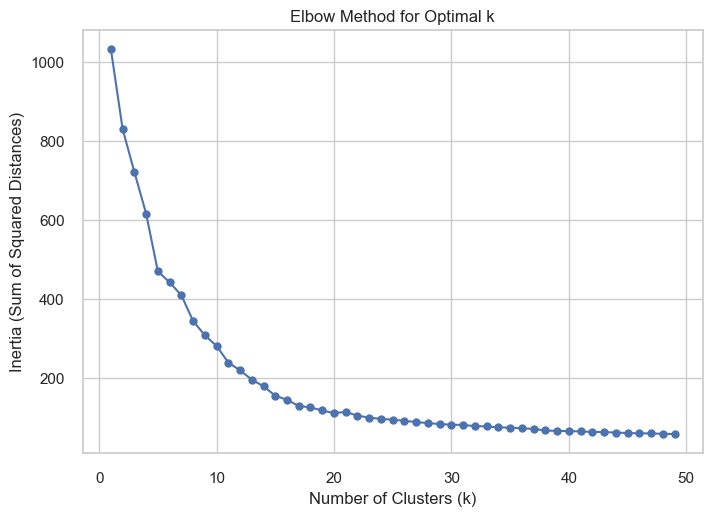

In [228]:
inertias_embedding = evaluate_elbow_method(file_kernel_count)

In [130]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings


def evaluate_proportions(df, method='proportion', input=[0.01, 0.05, 0.1, 0.2], cluster_range=range(2, 41)):
    results = []

    for prop in input:
        if method=='proportion':
            print(f"Evaluating proportion = {prop:.2%}")
        else:
            print(f"Evaluating top {prop}")
        try:
            if method=='proportion':
                df_reduced = reduce_activations(df, mode=method, proportion=prop)
            else:
                df_reduced = reduce_activations(df, mode=method, n=prop)


            # Count activations per kernel per file
            file_kernel_count = df_reduced.pivot_table(
                index="filename",
                columns="kernel",
                values="amplitude",
                aggfunc="count",
                fill_value=0
            )

            # Normalize per row
            file_kernel_count = file_kernel_count.div(file_kernel_count.sum(axis=1), axis=0)

            best_silhouette = -1
            best_calinski = -1
            best_davies = float('inf')
            best_k_sil, best_k_cal, best_k_dav = None, None, None

            for k in cluster_range:
                model = KMeans(n_clusters=k, random_state=42).fit(file_kernel_count)
                labels = model.labels_

                # Skip invalid labelings
                if len(set(labels)) < 2:
                    continue

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sil = silhouette_score(file_kernel_count, labels)
                    cal = calinski_harabasz_score(file_kernel_count, labels)
                    dav = davies_bouldin_score(file_kernel_count, labels)

                if sil > best_silhouette:
                    best_silhouette = sil
                    best_k_sil = k

                if cal > best_calinski:
                    best_calinski = cal
                    best_k_cal = k

                if dav < best_davies:
                    best_davies = dav
                    best_k_dav = k

            results.append({
                'proportion': prop,
                'best_k_silhouette': best_k_sil,
                'silhouette_score': best_silhouette,
                'best_k_calinski': best_k_cal,
                'calinski_score': best_calinski,
                'best_k_davies': best_k_dav,
                'davies_score': best_davies
            })
        except Exception as e:
            print(f"Error at proportion {prop:.2%}: {e}")

    return pd.DataFrame(results)


In [ ]:
results_df = evaluate_proportions(df, input=[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3])

Evaluating proportion = 2.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 3.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 4.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 5.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 6.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 7.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 8.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 10.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 20.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


Evaluating proportion = 30.00%


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\2006930136.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(reduce_group)


In [62]:
from tabulate import tabulate

print(tabulate(
    results_df.sort_values("silhouette_score", ascending=False),
    headers='keys',
    tablefmt='pretty',
    floatfmt=".4f"
))

+---+------------+-------------------+---------------------+-----------------+--------------------+---------------+--------------------+
|   | proportion | best_k_silhouette |  silhouette_score   | best_k_calinski |   calinski_score   | best_k_davies |    davies_score    |
+---+------------+-------------------+---------------------+-----------------+--------------------+---------------+--------------------+
| 0 |    0.02    |       21.0        | 0.6840766998047774  |      32.0       | 3493.199936535058  |     21.0      | 0.7307781822693266 |
| 1 |    0.03    |       20.0        | 0.6466055379550795  |      25.0       | 2910.066828035899  |     20.0      | 0.742413059664285  |
| 4 |    0.06    |       20.0        | 0.5644474169271413  |      24.0       | 2295.0141776881906 |     20.0      | 0.7369409703062431 |
| 2 |    0.04    |       15.0        | 0.5581563616292838  |      29.0       | 2483.330316194401  |     15.0      | 0.7939123132957919 |
| 3 |    0.05    |       18.0        | 0.

In [131]:
results_df_top = evaluate_proportions(df, method='top_n', input=[100, 150, 200, 300, 400, 500, 1000])

print(tabulate(
    results_df_top.sort_values("silhouette_score", ascending=False),
    headers='keys',
    tablefmt='pretty',
    floatfmt=".4f"
))

Evaluating top 100


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\51654247.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)


Evaluating top 150


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\51654247.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)


Evaluating top 200


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\51654247.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)


Evaluating top 300


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\51654247.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)


Evaluating top 400


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\51654247.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)


Evaluating top 500


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\51654247.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)


Evaluating top 1000


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\51654247.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_df = df.groupby('filename', group_keys=False).apply(top_n_group)


+---+------------+-------------------+---------------------+-----------------+--------------------+---------------+--------------------+
|   | proportion | best_k_silhouette |  silhouette_score   | best_k_calinski |   calinski_score   | best_k_davies |    davies_score    |
+---+------------+-------------------+---------------------+-----------------+--------------------+---------------+--------------------+
| 0 |   100.0    |       22.0        | 0.49564911618913404 |      29.0       | 2074.4633881549184 |     29.0      | 0.8385437329862249 |
| 1 |   150.0    |       17.0        | 0.46193183769531915 |      32.0       | 1718.3997141697132 |     22.0      | 0.8495320925946012 |
| 2 |   200.0    |       27.0        | 0.4308366886802028  |      28.0       | 1518.0585548662543 |     26.0      | 0.9016893497740608 |
| 6 |   1000.0   |        2.0        | 0.38201246539760514 |      27.0       | 834.2801442698194  |     40.0      | 0.9886512352136807 |
| 3 |   300.0    |       20.0        | 0.

In [573]:
import colorsys
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

def plot_embedding_and_metrics(embedding, data_for_clustering, n_clusters, cluster_range=range(2, 40)):
    # Set styling first
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)
    plt.rcParams.update({
        "axes.labelsize": 22,
        "axes.titlesize": 24,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 18,
        "axes.edgecolor": "#444444",
        "axes.linewidth": 1.1,
        "grid.color": "#cccccc",
        "grid.linewidth": 0.8,
        "legend.frameon": False,
        "mathtext.fontset": "cm",
        "font.family": "DejaVu Sans", 
    })

    # Run clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data_for_clustering)
    labels = kmeans.labels_
    # hsv_palette = sns.color_palette("hsv", n_clusters)
    hsv_palette = sns.color_palette("hsv", n_clusters)

    # Convert each RGB color to HLS, reduce saturation a bit, increase lightness a bit
    def desaturate_and_lighten(rgb, saturation_factor=0.9, lightness_increase=0.01):
        h, l, s = colorsys.rgb_to_hls(*rgb)
        s = max(0, min(1, s * saturation_factor))       # reduce saturation
        l = max(0, min(1, l + lightness_increase))      # increase lightness
        return colorsys.hls_to_rgb(h, l, s)

    hsv_palette = [desaturate_and_lighten(c) for c in hsv_palette]
    silhouette_vals = silhouette_samples(data_for_clustering, labels)
    avg_silhouette = silhouette_score(data_for_clustering, labels)

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(4, 2, width_ratios=[1.5, 2], height_ratios=[1, 1, 1, 1.6], wspace=0.2, hspace=0.4)

    # UMAP
    ax_umap = fig.add_subplot(gs[:, 0])
    sns.scatterplot(
        x=embedding[:, 0], y=embedding[:, 1],
        hue=labels, palette=hsv_palette,
        s=5, ax=ax_umap, edgecolor='none', legend=False
    )
    ax_umap.set_title("Kernel Activation Counts")
    ax_umap.set_xlabel("UMAP Dim. 1")
    ax_umap.set_ylabel("UMAP Dim. 2")
    ax_umap.set_xticklabels([])
    ax_umap.set_yticklabels([])
    ax_umap.grid(False)

    # Clustering metric scores
    silhouette_scores, calinski_scores, davies_scores = [], [], []
    for k in cluster_range:
        kmeans_k = KMeans(n_clusters=k, random_state=42).fit(data_for_clustering)
        k_labels = kmeans_k.labels_
        silhouette_scores.append(silhouette_score(data_for_clustering, k_labels))
        calinski_scores.append(calinski_harabasz_score(data_for_clustering, k_labels))
        davies_scores.append(davies_bouldin_score(data_for_clustering, k_labels))

    best_k_sil = cluster_range[np.argmax(silhouette_scores)]
    best_k_cal = cluster_range[np.argmax(calinski_scores)]
    best_k_dav = cluster_range[np.argmin(davies_scores)]

    # Plot 1: Silhouette
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='deepskyblue', linewidth=2, label="Silhouette Score")
    ax1.axvline(best_k_sil, linestyle='--', color='deepskyblue', alpha=0.5, linewidth=2.1)
    ax1.set_ylabel("Sil.")
    ax1.set_xlim(min(cluster_range), max(cluster_range))
    ax1.grid(True, linestyle=':', alpha=0.7)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_xlabel(r"Number of Clusters ($\mathrm{k} \in \{2, \dots, 40\}$)")
    ax1.legend(loc="lower right", frameon=False)

    # Set ticks including 17
    regular_ticks = list(range(min(cluster_range), max(cluster_range) + 1))
    major_ticks = [tick for tick in regular_ticks if tick % 5 == 0]

    # Combine major ticks and add 17 if not already included
    if best_k_sil not in major_ticks and best_k_sil in regular_ticks:
        major_ticks.append(best_k_sil)
    major_ticks = sorted(major_ticks)

    ax1.set_xticks(major_ticks)

    # Now, color the ticks: 17 in deepskyblue, others default
    def color_ticks(ax, highlight_tick, highlight_color):
        for tick in ax.get_xticklabels():
            if tick.get_text() == str(highlight_tick):
                tick.set_color(highlight_color)
            else:
                tick.set_color('black')  # or any default color

    color_ticks(ax1, best_k_sil, 'deepskyblue')

    # Silhouette plot annotation
    best_k_sil_idx = np.argmax(silhouette_scores)
    best_k_sil_value = silhouette_scores[best_k_sil_idx]
    best_k_sil_x = cluster_range[best_k_sil_idx]
    ax1.annotate(
        f"{best_k_sil_value:.3f}",
        xy=(best_k_sil_x, best_k_sil_value),
        xytext=(best_k_sil_x + 1, best_k_sil_value - 0.07),
        arrowprops=dict(
            facecolor='orangered', 
            edgecolor='orangered',  # add edge color
            arrowstyle='->',
            alpha=0.7, 
            lw=1.5
        ),
        fontsize=16, color='orangered'
    )

    # Plot 2: Calinski–Harabasz
    calinski_scores_scaled = np.array(calinski_scores) / 1000
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.plot(cluster_range, calinski_scores_scaled, marker='s', linestyle='-', color='yellowgreen', linewidth=2, label="Calinski–Harabasz Index")
    ax2.axvline(best_k_cal, linestyle='--', color='yellowgreen', alpha=0.5, linewidth=2.1)
    ax2.set_ylabel("CH (×10³)")
    ax2.set_xlim(min(cluster_range), max(cluster_range))
    ax2.grid(True, linestyle=':', alpha=0.7)
    ax2.set_xticks([best_k_cal])               # Only one tick at best_k_cal
    ax2.set_xticklabels([str(best_k_cal)])    # Label only that tick
    ax2.xaxis.set_ticks_position('top')       # Tick labels on top
    ax2.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
    for tick in ax2.get_xticklabels():
        tick.set_color('yellowgreen')  
    ax2.legend(loc="lower right", frameon=False, fontsize=17)

    # Calinski–Harabasz plot annotation
    best_k_cal_idx = np.argmax(calinski_scores_scaled)
    best_k_cal_value = calinski_scores_scaled[best_k_cal_idx]
    best_k_cal_x = cluster_range[best_k_cal_idx]
    ax2.annotate(
        f"{int(best_k_cal_value * 1000)}",
        xy=(best_k_cal_x, best_k_cal_value),
        xytext=(best_k_cal_x - 5, best_k_cal_value - 0.2),
        arrowprops=dict(
            facecolor='orangered', 
            edgecolor='orangered',  # add edge color
            arrowstyle='->',
            alpha=0.7, 
            lw=1.5
        ),
        fontsize=16, color='orangered'
    )

    # Plot 3: Davies–Bouldin
    ax3 = fig.add_subplot(gs[2, 1])
    ax3.plot(cluster_range, davies_scores, marker='^', linestyle='-', color='tomato', linewidth=2, label="Davies–Bouldin Index")
    ax3.axvline(best_k_dav, linestyle='--', color='tomato', alpha=0.8, linewidth=2.1)
    ax3.set_ylabel("DBI")
    ax3.grid(True, linestyle=':', alpha=0.7)
    ax3.set_xticks([best_k_dav])               # Only one tick at best_k_dav
    ax3.set_xticklabels([str(best_k_dav)])    # Label only that tick
    ax3.xaxis.set_ticks_position('top')       # Tick labels on top
    ax3.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
    for tick in ax3.get_xticklabels():
        tick.set_color('tomato')
    ax3.legend(loc="upper right", frameon=False)

    # Davies–Bouldin plot annotation
    best_k_dav_idx = np.argmin(davies_scores)
    best_k_dav_value = davies_scores[best_k_dav_idx]
    best_k_dav_x = cluster_range[best_k_dav_idx]
    ax3.annotate(
        f"{best_k_dav_value:.3f}",
        xy=(best_k_dav_x, best_k_dav_value),
        xytext=(best_k_dav_x - 5.3, best_k_dav_value + 0.2),
        arrowprops=dict(
            facecolor='orangered', 
            edgecolor='orangered',  # add edge color
            arrowstyle='->',
            alpha=0.7, 
            lw=1.5
        ),
        fontsize=16, color='orangered'
    )

    # Silhouette Detail
    ax4 = fig.add_subplot(gs[3, 1])
    y_lower = 10
    ax4.set_xlim([-0.1, 1])
    ax4.set_ylim([0, len(data_for_clustering) + (n_clusters + 1) * 10])
    ax4.set_xlabel("Sil. Coef.")
    ax4.set_ylabel("Cluster")
    ax4.grid(True, linestyle=':', alpha=0.5)
    ax4.set_yticks([])
    ax4.tick_params(axis='y', left=False)

    for i in range(n_clusters):
        ith_vals = np.sort(silhouette_vals[labels == i])
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i
        ax4.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                          facecolor=hsv_palette[i], edgecolor=hsv_palette[i], alpha=0.75)
        y_lower = y_upper + 10

    ax4.axvline(x=avg_silhouette, color="#444444", linestyle="--", alpha=0.5, linewidth=2)
    ax4.set_title(fr"Silhouette Coefficients ($\mathrm{{k = {n_clusters}}}$)", fontsize=22, pad=10)

    plt.tight_layout()
    plt.show()
    return fig


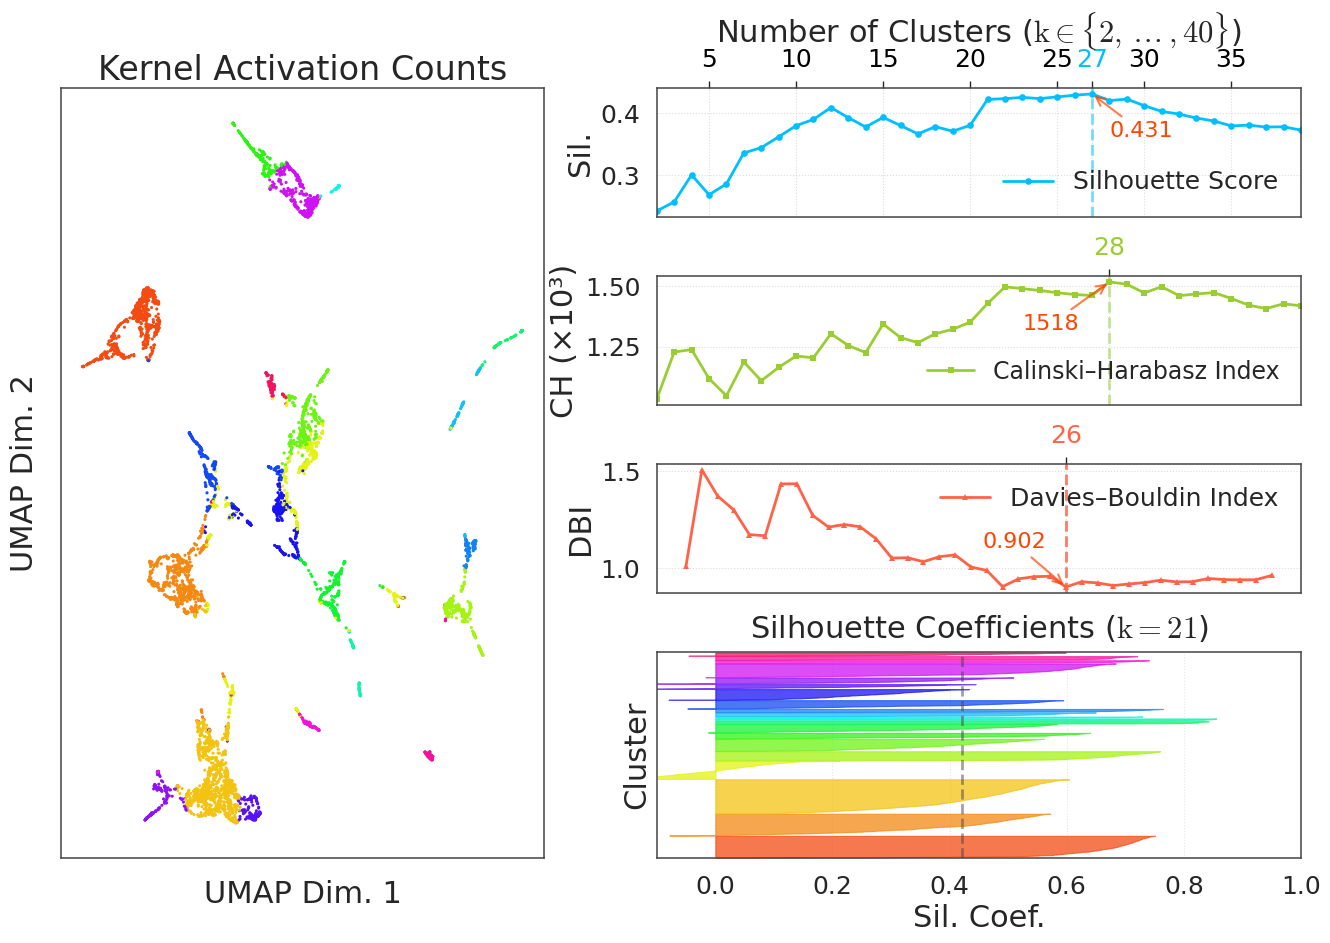

In [ ]:
clusters_raw = cluster_with_kmeans(file_kernel_count, n_clusters=21)
fig = plot_embedding_and_metrics(embedding, file_kernel_count, n_clusters=21, cluster_range=range(2, 40))


In [389]:
fig.savefig("diagrams\clustering_visualization.pdf", bbox_inches='tight')


In [ ]:
def gini_coefficient(x):
    """
    Compute the Gini coefficient of a numpy array.
    Gini = 0 means perfect equality; Gini = 1 means maximal inequality.
    """
    # Ensure array is 1D and non-negative
    x = np.sort(np.abs(x))
    n = len(x)
    if n == 0:
        return np.nan
    if np.sum(x) == 0:
        return 0.0
    cumulative_sum = np.cumsum(x)
    relative_cumsum = cumulative_sum / cumulative_sum[-1]
    gini = 1 - 2 * np.sum(relative_cumsum) / n + (1 / n)
    return gini


In [ ]:
def hoyer_sparsity(array):
    """Calculate Hoyer sparsity of a 1D array."""
    array = np.abs(array)
    n = len(array)
    if np.all(array == 0):
        return 0.0
    l1_norm = np.sum(array)
    l2_norm = np.sqrt(np.sum(array ** 2))
    sparsity = (np.sqrt(n) - l1_norm / l2_norm) / (np.sqrt(n) - 1)
    return sparsity


In [577]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl


def plot_cluster_kernel_heatmap_sparse_filtered(
    file_kernel_count: pd.DataFrame,
    df_reduced: pd.DataFrame,
    clusters_raw,
    amp_threshold: float = None,
    normalize_rows: bool = True,
    figsize=(10, 6),
    threshold=0.4,
    cmap='viridis'
):
    
    mpl.rcParams["axes.edgecolor"] = "#444444"
    mpl.rcParams["axes.linewidth"] = 1.5
    # Auto threshold if not set
    if amp_threshold is None:
        amp_threshold = 0.05 * df_reduced['amplitude'].max()

    print(f"Using amplitude threshold: {amp_threshold:.3f}")

    # Filter df_reduced to exclude near-zero amplitudes
    df_reduced_filtered = df_reduced[df_reduced['amplitude'].abs() >= amp_threshold].copy()

    # Rebuild file_kernel_count_filtered using only significant activations
    file_kernel_count_filtered = df_reduced_filtered.groupby(['filename', 'kernel'])['amplitude'].count().unstack(fill_value=0)

    # Align with original index order and fill missing files/kernels
    file_kernel_count_filtered = file_kernel_count_filtered.reindex(columns=range(file_kernel_count.shape[1]), fill_value=0)
    file_kernel_count_filtered = file_kernel_count_filtered.reindex(index=file_kernel_count.index, fill_value=0)

    file_kernel_count_array = file_kernel_count_filtered.to_numpy()
    n_clusters = np.max(clusters_raw) + 1
    n_kernels = file_kernel_count_array.shape[1]

    # Aggregate: cluster mean activation per kernel
    heatmap_data = np.zeros((n_clusters, n_kernels))
    for cluster_id in range(n_clusters):
        mask = (clusters_raw == cluster_id)
        cluster_data = file_kernel_count_array[mask]
        if cluster_data.shape[0] == 0:
            continue
        heatmap_data[cluster_id] = cluster_data.mean(axis=0)

    if normalize_rows:
        heatmap_data = heatmap_data / (heatmap_data.sum(axis=1, keepdims=True) + 1e-9)  # avoid divide by zero

    heatmap_display = heatmap_data * 100  # convert to percentages for display

    # Plot heatmap
    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(
        heatmap_display,
        cmap=cmap,
        cbar=True,
        xticklabels=False,
        yticklabels=False,
        linewidths=0,
        linecolor='white'
    )

    # Add dark gray frame manually
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("#444444")
        spine.set_linewidth(1.5)



    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
    colorbar.set_ticklabels([f"{int(t)}%" for t in [0, 10, 20, 30, 40, 50, 60, 70, 80]])


    ax.text(0 + 0.5, heatmap_display.shape[0] + 0.8, '1', ha='center', va='center', fontsize=17)
    ax.text(n_kernels - 1 + 0.5, heatmap_display.shape[0] + 0.8, str(n_kernels), ha='center', va='center', fontsize=17)
    ax.text(-0.6, 0 + 0.5, '1', ha='center', va='center', fontsize=17)
    ax.text(-0.6, n_clusters - 1 + 0.5, str(n_clusters), ha='center', va='center', fontsize=17)

    
    # Get the colormap object from seaborn (matplotlib under the hood)
    cmap_obj = mpl.cm.get_cmap(cmap)

    # Normalize the heatmap data to [0, 1] for color mapping
    norm = mpl.colors.Normalize(vmin=heatmap_display.min(), vmax=heatmap_display.max())

    for i in range(heatmap_display.shape[0]):
        for j in range(heatmap_display.shape[1]):
            value = heatmap_display[i, j]
            if value > threshold * 100:
                rgba = cmap_obj(norm(value))
                ax.annotate(f"{value:.0f}%",
                            xy=(j + 1, i + 0.5),
                            xytext=(j + 3.4, i + 0.55),
                            textcoords='data',
                            ha='center', va='center',
                            fontsize=16,
                            color=rgba,
                            arrowprops=dict(facecolor=rgba,
                                            edgecolor=rgba,
                                            arrowstyle='->',
                                            lw=1.5))


    plt.xlabel("Kernel (1 to {})".format(n_kernels))
    plt.ylabel("Cluster (1 to {})".format(n_clusters))
    plt.tight_layout()
    plt.show()

        # Step 1: Compute inactive ratios and cluster sizes
    inactive_ratios = []
    cluster_sizes = []

    for cluster_id in range(n_clusters):
        row = heatmap_data[cluster_id]
        num_inactive = np.sum(row < 0.01)
        inactive_ratio = num_inactive / n_kernels
        inactive_ratios.append(inactive_ratio)

        size = np.sum(clusters_raw == cluster_id)
        cluster_sizes.append(size)

    # Step 2: Compute weighted mean
    inactive_ratios = np.array(inactive_ratios)
    cluster_sizes = np.array(cluster_sizes)

    weighted_mean_inactive = np.average(inactive_ratios, weights=cluster_sizes)

    # Output
    # print("Inactive ratio per cluster:")
    # for cid, ratio in enumerate(inactive_ratios):
    #     print(f"  Cluster {cid + 1}: {ratio:.2%}")

    print(f"\nWeighted mean inactive ratio across all clusters: {weighted_mean_inactive:.2%}")

    
    gini_per_cluster = []
    hoyer_per_cluster = []

    for row in heatmap_data:
        gini_per_cluster.append(gini_coefficient(row))
        hoyer_per_cluster.append(hoyer_sparsity(row))

    print("Gini indices per cluster:", gini_per_cluster)
    print("Hoyer sparsity per cluster:", hoyer_per_cluster)

    # Optionally, overall measures
    gini_overall = gini_coefficient(heatmap_data.flatten())
    hoyer_overall = hoyer_sparsity(heatmap_data.flatten())

    print(f"Overall Gini: {gini_overall:.4f}")
    print(f"Overall Hoyer sparsity: {hoyer_overall:.4f}")
    return fig




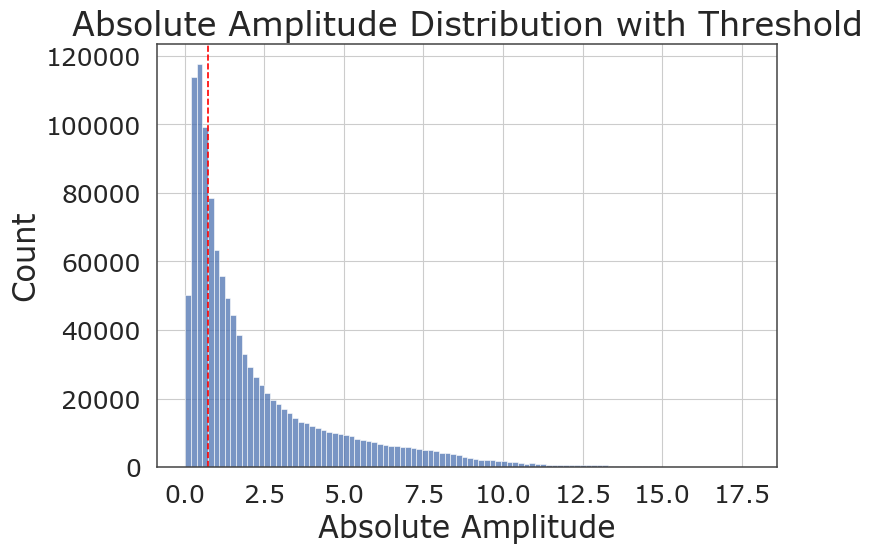

In [344]:
sns.histplot(df_reduced['amplitude'].abs(), bins=100)
plt.axvline(0.0425 * df_reduced['amplitude'].max(), color='red', linestyle='--')
plt.title('Absolute Amplitude Distribution with Threshold')
plt.xlabel('Absolute Amplitude')
plt.ylabel('Count')
plt.show()


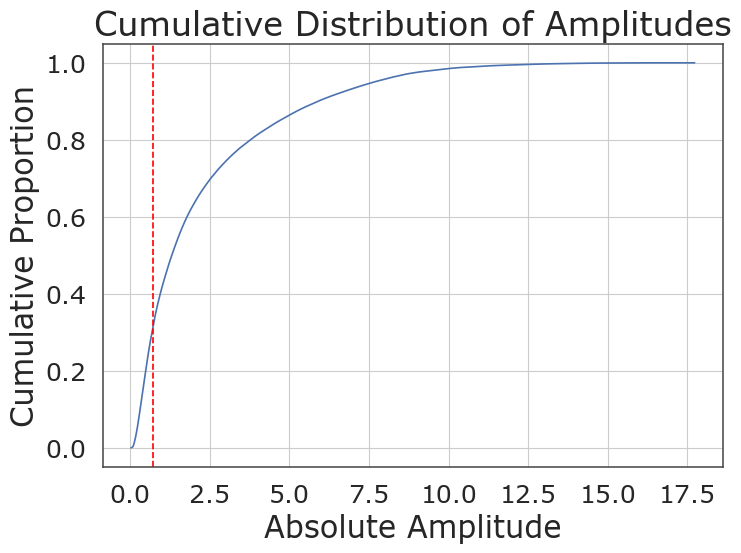

In [343]:
amps = df_reduced['amplitude'].abs().sort_values()
cdf = np.linspace(0, 1, len(amps))

plt.plot(amps, cdf)
plt.xlabel("Absolute Amplitude")
plt.ylabel("Cumulative Proportion")
plt.axvline(x=0.0425 * df_reduced['amplitude'].max(), color='red', linestyle='--')
plt.title("Cumulative Distribution of Amplitudes")
plt.grid(True)
plt.show()

In [302]:
def idk(waveform, sr, dictionary, indices, amps, time_idxs, 
                                 left=0.015, right=0.01, fontsize=16):
    
    reconstructed = np.zeros_like(waveform)

    for idx, amp, t in zip(indices, amps, time_idxs):
        k = dictionary[idx].kernel
        norm_k = np.linalg.norm(k)
        if norm_k > 0:
            k_normalized = k / norm_k
            adjusted_amp = amp * norm_k
        else:
            k_normalized = k
            adjusted_amp = amp

        t_start = t
        t_end = t + len(k_normalized)

        if t_start < 0:
            k_normalized = k_normalized[-t_start:]
            t_start = 0
        if t_end > len(reconstructed):
            k_normalized = k_normalized[:len(reconstructed) - t_start]

        reconstructed[t_start:t_start + len(k_normalized)] += adjusted_amp * k_normalized

    signal_power = np.sum(np.square(waveform))
    noise_power = np.sum(np.square(waveform - reconstructed))
    snr = float('inf') if noise_power == 0 else 10 * np.log10(signal_power / noise_power)
    # print(f"Reconstruction SNR: {snr:.2f} dB")
    return snr


Computing SNR/bitrate: 100%|██████████| 1000/1000 [00:04<00:00, 228.60it/s]


Mean SNR: 20.00 dB


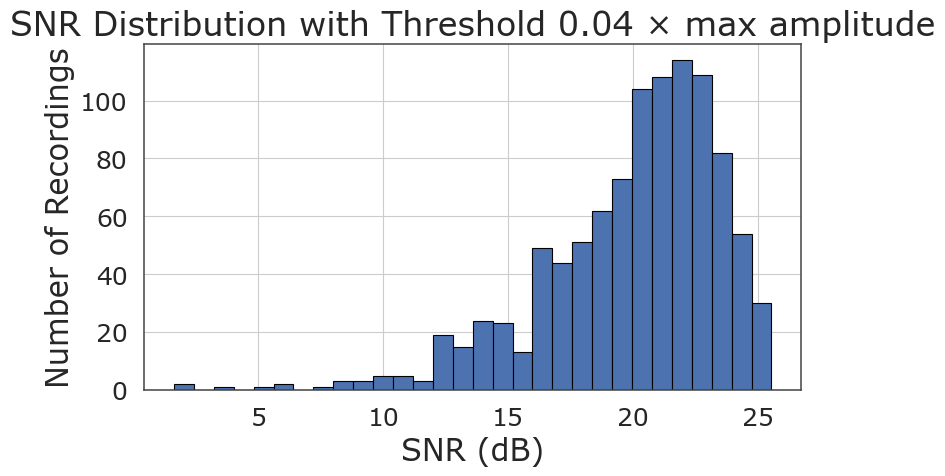

In [339]:
amplitude_threshold_ratio = 0.0425
snrs = []
# Compute SNR and bitrate
for waveform, file_activations in tqdm(zip(waveforms, activations_list), total=len(waveforms), desc="Computing SNR/bitrate"):
    indices, amps, time_idxs = extract_mp_components(file_activations, 100000)

    # Apply amplitude threshold
    abs_amp = np.abs(amps)
    threshold = amplitude_threshold_ratio * abs_amp.max() if len(abs_amp) > 0 else 0
    mask = abs_amp >= threshold
    indices = np.array(indices)[mask]
    amps = np.array(amps)[mask]
    time_idxs = np.array(time_idxs)[mask]

    
    snr = idk(
        waveform, sr, dictionary, indices, amps, time_idxs,
        left=0.001, right=0.001
    )

    snrs.append(snr)
mean_snr = np.mean(snrs)
print(f"Mean SNR: {mean_snr:.2f} dB")
# Plot SNR distribution
plt.figure(figsize=(8, 5))
plt.hist(snrs, bins=30, edgecolor='black')
plt.xlabel('SNR (dB)')
plt.ylabel('Number of Recordings')
plt.title(f'SNR Distribution with Threshold {amplitude_threshold_ratio:.2f} × max amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


Computing SNR/bitrate:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing SNR/bitrate: 100%|██████████| 1000/1000 [00:06<00:00, 157.78it/s]


Mean SNR: 11.08 dB


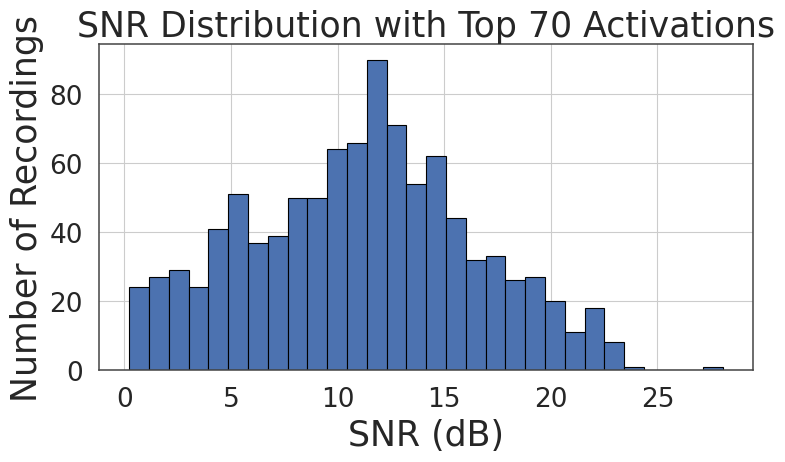

In [1007]:
top_k = 70
snrs = []

# Compute SNR and bitrate
for waveform, file_activations in tqdm(zip(waveforms, activations_list), total=len(waveforms), desc="Computing SNR/bitrate"):
    indices, amps, time_idxs = extract_mp_components(file_activations, 100000)

    # Sort by absolute amplitude and select top_k
    abs_amp = np.abs(amps)
    if len(abs_amp) == 0:
        continue  # Skip empty activation sets

    sorted_idxs = np.argsort(-abs_amp)  # Sort descending
    top_idxs = sorted_idxs[:top_k]

    indices = np.array(indices)[top_idxs]
    amps = np.array(amps)[top_idxs]
    time_idxs = np.array(time_idxs)[top_idxs]

    snr = idk(
        waveform, sr, dictionary, indices, amps, time_idxs,
        left=0.001, right=0.001
    )

    snrs.append(snr)

mean_snr = np.mean(snrs)
print(f"Mean SNR: {mean_snr:.2f} dB")

# Plot SNR distribution
plt.figure(figsize=(8, 5))
plt.hist(snrs, bins=30, edgecolor='black')
plt.xlabel('SNR (dB)')
plt.ylabel('Number of Recordings')
plt.title(f'SNR Distribution with Top {top_k} Activations')
plt.grid(True)
plt.tight_layout()
plt.show()


Using amplitude threshold: 0.732


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\828989774.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)


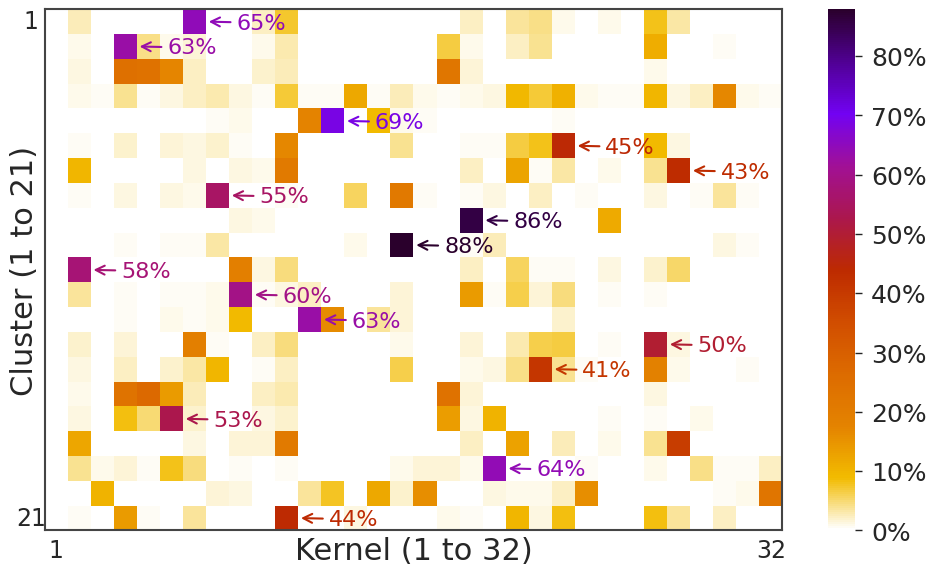


Weighted mean inactive ratio across all clusters: 69.98%
Gini indices per cluster: [np.float64(0.8847071449902941), np.float64(0.8819020288307529), np.float64(0.8442426604785525), np.float64(0.6208012716669367), np.float64(0.9264250814332248), np.float64(0.8386642278030453), np.float64(0.8702525317512206), np.float64(0.8508111482750493), np.float64(0.9561817072494315), np.float64(0.9296603855439867), np.float64(0.8958201566605041), np.float64(0.8642017942910696), np.float64(0.9044676051867973), np.float64(0.8547965722443218), np.float64(0.8111382867006253), np.float64(0.8519568951130643), np.float64(0.8688920825712045), np.float64(0.857381907176977), np.float64(0.8432582612116444), np.float64(0.7757125635279523), np.float64(0.8386020881670534)]
Hoyer sparsity per cluster: [np.float64(0.8893734859599195), np.float64(0.8834448879370796), np.float64(0.7334351877849244), np.float64(0.4872333225849739), np.float64(0.9149449381871457), np.float64(0.7847279241941977), np.float64(0.7930007988

In [599]:
file_kernel_count = df_reduced.pivot_table(
    index="filename",
    columns="kernel",
    values="amplitude",
    aggfunc="count",
    fill_value=0
)
import matplotlib.colors as mcolors

def create_white_to_gnuplot_colormap():
    base_cmap = plt.get_cmap('gnuplot_r')
    
    # Start with white, then sample gnuplot at specified points
    sample_points = [0.1, 0.2, 0.25, 0.33, 0.45, 0.55, 0.6, 0.8, 0.9, 0.97]
    sampled_colors = [base_cmap(p) for p in sample_points]

    # Insert white at the beginning
    color_list = [(1, 1, 1, 1)] + sampled_colors

    # Create a new LinearSegmentedColormap with linear interpolation
    return mcolors.LinearSegmentedColormap.from_list('custom_gnuplot', color_list, N=256)

# Then in your plotting function call:
cmap_custom = create_white_to_gnuplot_colormap()


fig = plot_cluster_kernel_heatmap_sparse_filtered(
    file_kernel_count=file_kernel_count,
    df_reduced=df,
    clusters_raw=clusters_raw,
    amp_threshold=0.0425 * df_reduced['amplitude'].max(),
    normalize_rows=True,
    threshold=0.4,
    cmap=cmap_custom
)



In [396]:
fig.savefig("diagrams\sparsity.pdf", bbox_inches='tight')

In [207]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.signal import spectrogram
import soundfile as sf  # for loading audio

def plot_top_central_spectrograms(
    file_kernel_count: pd.DataFrame,
    folder: str,
    n_clusters: int = 17,
    top_n: int = 7,
    random_state: int = 42
):
    """
    Cluster the rows of `file_kernel_count` using KMeans, then plot
    spectrograms of the top_n most central files per cluster in a grid of 7 columns.

    Args:
        file_kernel_count: DataFrame with filenames as index and kernel counts as columns.
        folder: Folder path where raw .wav files are stored.
        n_clusters: Number of KMeans clusters.
        top_n: Number of most central files to plot per cluster.
        random_state: Random seed for reproducibility.
    """
    def short_filename_id(fname):
        """Extracts the ID in the format 1704-19 from the full filename."""
        match = re.search(r"A00?(\d+)_.*?_call_(\d+)_", fname)
        if match:
            return f"{match.group(1)}-{match.group(2)}"
        else:
            return fname  # fallback if parsing fails

    filenames = file_kernel_count.index.tolist()

    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(file_kernel_count)
    centers = kmeans.cluster_centers_

    # Compute distances to cluster centers
    distances = np.zeros(len(filenames))
    for idx, (label, features) in enumerate(zip(labels, file_kernel_count.values)):
        center = centers[label]
        distances[idx] = np.linalg.norm(features - center)

    # Create DataFrame for easy querying
    df_clustered = pd.DataFrame({
        'filename': filenames,
        'cluster': labels,
        'distance_to_center': distances
    })

    def plot_spectrogram(wav_path, ax, title=None):
        y, sr = sf.read(wav_path)
        if y.ndim > 1:
            y = y[:, 0]

        f, t, Sxx = spectrogram(y, fs=sr, nperseg=1024, noverlap=768)
        t_ms = t * 1000
        pcm = ax.pcolormesh(t_ms, f / 1000, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
        ax.set_ylabel('Frequency [kHz]')
        ax.set_xlabel('Time [ms]')
        if title:
            ax.set_title(title)
        ax.label_outer()
        return pcm  # return the QuadMesh for colorbar

    for cluster_id in range(n_clusters):
        cluster_files = df_clustered[df_clustered['cluster'] == cluster_id]
        cluster_files_sorted = cluster_files.sort_values('distance_to_center').head(top_n)

        n_plots = len(cluster_files_sorted)
        cols = 7
        rows = math.ceil(n_plots / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3))
        fig.suptitle(f"Cluster {cluster_id} - Top {top_n} Central Files")

        # Flatten axes array for easy iteration, handles rows=1 case too
        if rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()

        # Turn off unused axes
        for ax in axes[n_plots:]:
            ax.axis('off')

        pcm = None
        for ax, (_, row) in zip(axes, cluster_files_sorted.iterrows()):
            filepath = os.path.join(folder, row['filename'])
            title = short_filename_id(row['filename'])
            pcm = plot_spectrogram(filepath, ax, title=title)

        # Add a single colorbar on the right for the entire figure

        plt.tight_layout(rect=[0, 0, 0.95, 0.95])
        plt.show()


In [475]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.signal import spectrogram
import soundfile as sf  # for loading audio

def plot_top_central_spectrograms(
    file_kernel_count: pd.DataFrame,
    folder: str,
    n_clusters: int = 17,
    top_n: int = 7,
    random_state: int = 42
):
    """
    Cluster the rows of `file_kernel_count` using KMeans, then plot
    spectrograms of the top_n most central files per cluster in a single figure.
    One row per cluster, one column per top_n sample.
    """
    filenames = file_kernel_count.index.tolist()

    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(file_kernel_count)
    centers = kmeans.cluster_centers_

    # Compute distances to cluster centers
    distances = np.linalg.norm(file_kernel_count.values - centers[labels], axis=1)

    # Create DataFrame for easy querying
    df_clustered = pd.DataFrame({
        'filename': filenames,
        'cluster': labels,
        'distance_to_center': distances
    })

    def plot_spectrogram(wav_path, ax):
        y, sr = sf.read(wav_path)
        if y.ndim > 1:
            y = y[:, 0]
        f, t, Sxx = spectrogram(y, fs=sr, nperseg=1024, noverlap=768)
        t_ms = t * 1000
        ax.pcolormesh(t_ms, f / 1000, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

    # Create a large grid of subplots: rows = clusters, cols = top_n
    fig, axes = plt.subplots(n_clusters, top_n, figsize=(top_n * 2, n_clusters * 2), squeeze=False)

    for cluster_id in tqdm(range(n_clusters)):
        cluster_files = df_clustered[df_clustered['cluster'] == cluster_id]
        cluster_files_sorted = cluster_files.sort_values('distance_to_center').head(top_n)

        for i, (_, row) in enumerate(cluster_files_sorted.iterrows()):
            filepath = os.path.join(folder, row['filename'])
            ax = axes[cluster_id, i]
            plot_spectrogram(filepath, ax)

        # Hide unused axes in the row (if fewer than top_n)
        for j in range(len(cluster_files_sorted), top_n):
            axes[cluster_id, j].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout(pad=0)
    plt.show()


In [70]:
file_kernel_count = df_reduced.pivot_table(
    index="filename",
    columns="kernel",
    values="amplitude",
    aggfunc="count",
    fill_value=0
)


In [ ]:
folder = "high_rhinolophus_affinis_segments"
plot_top_central_spectrograms(file_kernel_count, folder, n_clusters=27, top_n=10)


In [68]:
from matplotlib import rcParams
LABEL_FONT_SIZE = 25
TICK_FONT_SIZE = 19
ANNOTATION_FONT_SIZE = 19

# Set global matplotlib font settings
rcParams.update({
    'font.size': TICK_FONT_SIZE,
    'xtick.labelsize': TICK_FONT_SIZE,
    'ytick.labelsize': TICK_FONT_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'axes.titlesize': LABEL_FONT_SIZE,
})

SPECIAL_LABEL_POSITIONS = {
    5: [3],
    13: [2, 3],
    15: [1, 3, 4],
    21: [4, 6, 7],
    23: [5, 6],
    24: [1, 6, 7],
    26: [2, 3, 4, 5, 6],
}

def should_use_custom_position(cluster_id, col_id):
    return cluster_id in SPECIAL_LABEL_POSITIONS and col_id in SPECIAL_LABEL_POSITIONS[cluster_id]


def plot_top_central_spectrograms(
    file_kernel_count: pd.DataFrame,
    folder: str,
    n_clusters: int = 27,
    top_n: int = 7,
    cluster_ids: list = None,
    random_state: int = 42,
    cmap='plasma'
):
    filenames = file_kernel_count.index.tolist()

    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(file_kernel_count)
    centers = kmeans.cluster_centers_

    # Compute distances to cluster centers
    distances = np.linalg.norm(file_kernel_count.values - centers[labels], axis=1)

    # Create DataFrame for easy querying
    df_clustered = pd.DataFrame({
        'filename': filenames,
        'cluster': labels,
        'distance_to_center': distances
    })

    def plot_spectrogram(wav_path, ax, duration, show_yaxis=False, cluster_id=None, col_id=None):
        y, sr = sf.read(wav_path)
        if y.ndim > 1:
            y = y[:, 0]
        f, t, Sxx = spectrogram(y, fs=sr, nperseg=1024, noverlap=768)
        t_ms = t * 1000  # convert to ms

        ax.pcolormesh(t_ms, f / 1000, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap=cmap)
        ax.set_xticks([])
        ax.set_xlabel("")  

        if show_yaxis:
            if cluster_id == 26:
                ax.set_yticks([f[0]/1000, (f[0] + f[-1])/2000, f[-1]/1000])
                ax.set_yticklabels([f"{f[0]/1000:.0f}", f"{(f[0] + f[-1])/2000:.0f}", f"{f[-1]/1000:.0f}"])
            else:
                ax.set_yticks([(f[0] + f[-1])/2000, f[-1]/1000])
                ax.set_yticklabels([f"{(f[0] + f[-1])/2000:.0f}", f"{f[-1]/1000:.0f}"])
        else:
            ax.set_yticks([])

        ax.tick_params(labelsize=TICK_FONT_SIZE)        

        avg_power = np.mean(Sxx, axis=1)
        peak_idx = np.argmax(avg_power)
        peak_freq_khz = f[peak_idx] / 1000

        # Peak frequency annotation
        # if cluster_id in [4, 5, 7, 11, 12, 14, 19, 21, 23, 24, 26]:
        if should_use_custom_position(cluster_id, col_id):
            ax.text(0.5, 0.18, f"{duration * 1000:.0f}",
                    fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top', transform=ax.transAxes)
            ax.text(0.5, 0.57, f"{peak_freq_khz:.1f}",
                    fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top',
                    color=(0.3, 0.025, 0.7), transform=ax.transAxes)
        elif cluster_id in [4, 5, 7, 11, 12, 14, 19, 21, 23, 24, 26]:
            ax.text(0.5, 0.18, f"{duration * 1000:.0f} ms",
            fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top', transform=ax.transAxes)
            ax.text(0.5, 0.57, f"{peak_freq_khz:.1f} kHz",
                fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top',
                color=(0.3, 0.025, 0.7), transform=ax.transAxes)
        elif cluster_id == 1 and col_id in [0, 1, 2, 7]:
            ax.text(0.5, 0.18, f"{duration * 1000:.0f} ms",
                fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top', transform=ax.transAxes)
            ax.text(0.5, 0.37, f"{peak_freq_khz:.1f} kHz",
                fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top',
                color=(0.3, 0.025, 0.7), transform=ax.transAxes)
        else:
            ax.text(0.5, 0.18, f"{duration * 1000:.0f} ms",
                fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top', transform=ax.transAxes)
            ax.text(0.5, 0.94, f"{peak_freq_khz:.1f} kHz",
                fontsize=ANNOTATION_FONT_SIZE, ha='center', va='top',
                color=(0.3, 0.025, 0.7), transform=ax.transAxes)

        

    if cluster_ids is None:
        cluster_ids = list(range(n_clusters))
    else:
        cluster_ids = sorted(cluster_ids)

    durations = {}

    for cluster_id in cluster_ids:
        cluster_files = df_clustered[df_clustered['cluster'] == cluster_id]
        cluster_files_sorted = cluster_files.sort_values('distance_to_center').head(top_n)
        durations[cluster_id] = []

        for _, row in cluster_files_sorted.iterrows():
            filepath = os.path.join(folder, row['filename'])
            y, sr = sf.read(filepath)
            if y.ndim > 1:
                y = y[:, 0]
            duration_sec = len(y) / sr
            durations[cluster_id].append(duration_sec)

    fig = plt.figure(figsize=(top_n * 2.2 + 0.66, len(cluster_ids) * 2.2 + 0.05))
    outer = gridspec.GridSpec(
        len(cluster_ids), 1,
        height_ratios=[1]*len(cluster_ids),
        hspace=0, left=0.09, right=0.88
    )

    dummy_data = np.random.rand(100, 100)
    dummy_img = plt.imshow(dummy_data, cmap=cmap)
    plt.clf()

    for row_idx, cluster_id in enumerate(tqdm(cluster_ids)):
        cluster_files = df_clustered[df_clustered['cluster'] == cluster_id]
        cluster_files_sorted = cluster_files.sort_values('distance_to_center').head(top_n)
        dur = durations[cluster_id]
        inner = gridspec.GridSpecFromSubplotSpec(
            1, len(dur), subplot_spec=outer[row_idx], width_ratios=dur, wspace=0
        )

        for col_idx, (_, row) in enumerate(cluster_files_sorted.iterrows()):
            filepath = os.path.join(folder, row['filename'])
            ax = plt.Subplot(fig, inner[col_idx])
            plot_spectrogram(filepath, ax, duration=dur[col_idx], show_yaxis=(col_idx == 0),
                             cluster_id=cluster_id, col_id=col_idx)
            fig.add_subplot(ax)

        for j in range(len(cluster_files_sorted), top_n):
            ax = plt.Subplot(fig, inner[j])
            ax.axis('off')
            fig.add_subplot(ax)

    fig.text(0.0001, 0.5, "Frequency (kHz)", va='center', rotation='vertical', fontsize=LABEL_FONT_SIZE)
    fig.text(0.4, 0.08, "Time (ms)", va='center', rotation='horizontal', fontsize=LABEL_FONT_SIZE)

    cbar_ax = fig.add_axes([0.89, 0.11, 0.015, 0.77])
    cb = fig.colorbar(dummy_img, cax=cbar_ax)
    cb.ax.tick_params(labelsize=TICK_FONT_SIZE)
    cb.set_label("Power Spectral Density (dB)", fontsize=LABEL_FONT_SIZE)

    plt.tight_layout(pad=0.5)
    plt.show()


 18%|█▊        | 3/17 [00:01<00:04,  2.88it/s]


IndexError: index 1 is out of bounds for GridSpec with size 1

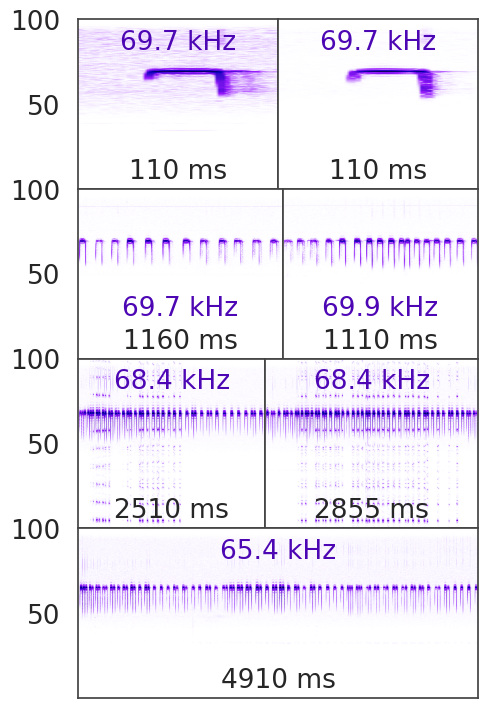

In [72]:
# Colors: white → bright bluish magenta → dark deep purple-blue
colors = [
    (1, 1, 1),          # white
    (0.6, 0.1, 1),      # vibrant magenta with bluish undertone (purple-ish)
    (0, 0, 0.7),      # darker purple-blue, deeper and darker earlier
    (0, 0, 0.2)   
]

# Create the colormap with non-linear stops for faster darkening
# The 'positions' control where colors are placed on [0,1], here darkens quicker
positions = [0.0, 0.4, 0.8, 1.0]

custom_cmap = LinearSegmentedColormap.from_list(
    'white_to_bluish_purple',
    list(zip(positions, colors)),
    N=256
)
plot_top_central_spectrograms(
    file_kernel_count=file_kernel_count,
    folder="high_rhinolophus_affinis_segments",
    n_clusters=17,
    top_n=2,
    # cluster_ids=[1, 6, 12, 20, 18],
	cmap = custom_cmap
)

In [165]:
import matplotlib.pyplot as plt

def plot_duration_histograms_per_cluster(df_clustered, n_clusters=17, bins=30):
    """
    Plot histograms of duration distributions for each cluster.

    Args:
        df_clustered: DataFrame containing at least 'duration' and 'cluster' columns.
        n_clusters: Number of clusters to plot histograms for.
        bins: Number of bins for histograms.
    """
    fig, axes = plt.subplots(5, 4, figsize=(21, 21))
    axes = axes.flatten()

    for cluster_id in range(n_clusters):
        ax = axes[cluster_id]
        cluster_durations = df_clustered[df_clustered['cluster'] == cluster_id]['duration']

        if cluster_durations.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        else:
            ax.hist(cluster_durations, bins=bins, color='skyblue', edgecolor='black')
        
        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Duration (seconds)')
        ax.set_ylabel('Count')

    # Hide any unused subplots if n_clusters < number of axes
    for i in range(n_clusters, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


In [93]:
import numpy as np
import pandas as pd
import re
from sklearn.cluster import KMeans

def create_clustered_df_with_durations(
    file_kernel_count: pd.DataFrame,
    folder: str,
    n_clusters: int = 17,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Performs KMeans clustering on `file_kernel_count` and extracts durations from filenames.
    Returns a DataFrame with columns: filename, cluster, distance_to_center, duration.
    """

    def extract_duration_from_filename(fname):
        match = re.search(r"_(\d+\.\d+)-(\d+\.\d+)s\.wav$", fname)
        if match:
            start = float(match.group(1))
            end = float(match.group(2))
            return end - start
        else:
            return np.nan  # Use NaN if duration can't be parsed

    filenames = file_kernel_count.index.tolist()

    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(file_kernel_count)
    centers = kmeans.cluster_centers_
    distances = np.linalg.norm(file_kernel_count.values - centers[labels], axis=1)

    # Build dataframe
    df_clustered = pd.DataFrame({
        'filename': filenames,
        'cluster': labels,
        'distance_to_center': distances
    })

    # Extract durations from filenames
    df_clustered['duration'] = df_clustered['filename'].apply(extract_duration_from_filename)

    # Optional: drop rows with NaN durations if any
    df_clustered = df_clustered.dropna(subset=['duration']).reset_index(drop=True)

    return df_clustered


In [200]:
df_clustered = create_clustered_df_with_durations(file_kernel_count, folder, n_clusters=27)

In [177]:
def print_cluster_sizes(df_clustered, n_clusters=17):
    """
    Print the number of samples (files) in each cluster.
    """
    for cluster_id in range(n_clusters):
        cluster_size = (df_clustered['cluster'] == cluster_id).sum()
        print(f"Cluster {cluster_id}: {cluster_size} files")


In [201]:
print_cluster_sizes(df_clustered, n_clusters=27)


Cluster 0: 653 files
Cluster 1: 633 files
Cluster 2: 1003 files
Cluster 3: 91 files
Cluster 4: 273 files
Cluster 5: 373 files
Cluster 6: 169 files
Cluster 7: 135 files
Cluster 8: 74 files
Cluster 9: 70 files
Cluster 10: 46 files
Cluster 11: 109 files
Cluster 12: 95 files
Cluster 13: 198 files
Cluster 14: 321 files
Cluster 15: 139 files
Cluster 16: 185 files
Cluster 17: 406 files
Cluster 18: 88 files
Cluster 19: 103 files
Cluster 20: 91 files
Cluster 21: 87 files
Cluster 22: 96 files
Cluster 23: 94 files
Cluster 24: 41 files
Cluster 25: 221 files
Cluster 26: 113 files


In [ ]:
def compute_gini(x):
    x = np.abs(np.asarray(x))
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x_sorted)) / (n * np.sum(x_sorted)) - (n + 1) / n

def compute_hoyer(x):
    x = np.abs(np.asarray(x))
    if np.all(x == 0):
        return 0.0
    l1 = np.sum(x)
    l2 = np.linalg.norm(x)
    n = len(x)
    return (np.sqrt(n) - l1 / l2) / (np.sqrt(n) - 1)

def compute_pq_mean(x, p=0.5, q=2):
    x = np.abs(np.asarray(x))
    if np.all(x == 0):
        return 0.0
    n = len(x)
    lp = np.power(np.sum(np.power(x, p)) / n, 1 / p)
    lq = np.power(np.sum(np.power(x, q)) / n, 1 / q)
    return lp / lq

def analyze_sparsity_indices(
    activations_list,
    kernel_counts=[50, 100, 200, 400, 800, 1600, 2400],
    species_labels=None,
    pq_pairs=[(0.5, 2), (1, 2)]
):
    if species_labels is None:
        species_labels = ['affinis'] * len(activations_list)

    gini_data = {k: [] for k in kernel_counts}
    hoyer_data = {k: [] for k in kernel_counts}
    pq_data = {pair: {k: [] for k in kernel_counts} for pair in pq_pairs}

    for n_kernels in tqdm(kernel_counts):
        for file_activations, species in zip(activations_list, species_labels):
            indices, amps, time_idxs = extract_mp_components(file_activations, n_kernels)
            amp_vector = np.zeros(n_kernels)
            for idx, amp in zip(indices, amps):
                if idx < n_kernels:
                    amp_vector[idx] += np.abs(amp)
            
            gini_val = compute_gini(amp_vector)
            hoyer_val = compute_hoyer(amp_vector)

            gini_data[n_kernels].append(gini_val)
            hoyer_data[n_kernels].append(hoyer_val)

            for pq in pq_pairs:
                pq_val = compute_pq_mean(amp_vector, p=pq[0], q=pq[1])
                pq_data[pq][n_kernels].append(pq_val)

    return gini_data, hoyer_data, pq_data


In [ ]:
def plot_sparsity_indices(gini_data_aff, hoyer_data_aff, gini_data_pea, hoyer_data_pea,
                          pq_data_aff, pq_data_pea, kernel_counts, pq_pairs):

    def get_means_stds(data_dict):
        means = [np.mean(data_dict[k]) for k in kernel_counts]
        stds = [np.std(data_dict[k]) for k in kernel_counts]
        return means, stds

    fig, ax = plt.subplots(figsize=(7.5, 5))
    ci_multiplier = 1.96 / np.sqrt(1000)

    # Plot Gini
    for data, label, style, color in [
        (gini_data_aff, "affinis (Gini)", '-', 'tomato'),
        (gini_data_pea, "pearsonii (Gini)", '--', 'tomato')
    ]:
        mean, std = get_means_stds(data)
        lower = np.array(mean) - ci_multiplier * np.array(std)
        upper = np.array(mean) + ci_multiplier * np.array(std)
        ax.plot(kernel_counts, mean, label=label, linestyle=style, color=color, marker='o')
        ax.fill_between(kernel_counts, lower, upper, color=color, alpha=0.15)

    # Plot Hoyer
    for data, label, style, color in [
        (hoyer_data_aff, "affinis (Hoyer)", '-', 'deepskyblue'),
        (hoyer_data_pea, "pearsonii (Hoyer)", '--', 'deepskyblue')
    ]:
        mean, std = get_means_stds(data)
        lower = np.array(mean) - ci_multiplier * np.array(std)
        upper = np.array(mean) + ci_multiplier * np.array(std)
        ax.plot(kernel_counts, mean, label=label, linestyle=style, color=color, marker='s')
        ax.fill_between(kernel_counts, lower, upper, color=color, alpha=0.10)

    # Plot PQ-Mean
    pq_colors = ['mediumseagreen', 'orchid', 'darkorange']
    for i, pq in enumerate(pq_pairs):
        for data, label, style in [
            (pq_data_aff[pq], f"affinis (pq={pq})", '-'),
            (pq_data_pea[pq], f"pearsonii (pq={pq})", '--')
        ]:
            mean, std = get_means_stds(data)
            lower = np.array(mean) - ci_multiplier * np.array(std)
            upper = np.array(mean) + ci_multiplier * np.array(std)
            ax.plot(kernel_counts, mean, label=label, linestyle=style, color=pq_colors[i % len(pq_colors)], marker='^')
            ax.fill_between(kernel_counts, lower, upper, color=pq_colors[i % len(pq_colors)], alpha=0.10)

    ax.set_xlabel("Number of Kernels", fontsize=13)
    ax.set_ylabel("Sparsity Index", fontsize=13)
    ax.set_title("Sparsity Indices (Gini, Hoyer, pq-Mean)", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=11)

    plt.tight_layout()
    plt.show()



In [835]:
pq_pairs = [(0.5, 2), (1, 2)]

gini_aff, hoyer_aff, pq_aff = analyze_sparsity_indices(activations_list, pq_pairs=pq_pairs)
gini_pea, hoyer_pea, pq_pea = analyze_sparsity_indices(activations_list_p, pq_pairs=pq_pairs)

100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


In [892]:
from scipy.stats import sem, t
import numpy as np

def summarize(values):
    values = np.array(values, dtype=float)
    mean = np.mean(values)
    std = np.std(values)
    n = len(values)
    if n > 1:
        ci = sem(values) * t.ppf(0.975, df=n-1)
    else:
        ci = 0.0
    return mean, std, ci

def print_summary_stats(k):
    g_aff = summarize(gini_aff[k])
    g_pea = summarize(gini_pea[k])
    h_aff = summarize(hoyer_aff[k])
    h_pea = summarize(hoyer_pea[k])
    pq_a = summarize(pq_aff[(0.5, 2)][k])
    pq_p = summarize(pq_pea[(0.5, 2)][k])

    print(f"Kernel {k} summary:")
    print(f"→ Gini aff: mean={g_aff[0]:.5f}, std={g_aff[1]:.5f}, 95% CI ±{g_aff[2]:.5f}")
    print(f"→ Gini pea: mean={g_pea[0]:.5f}, std={g_pea[1]:.5f}, 95% CI ±{g_pea[2]:.5f}")
    print(f"→ Hoyer aff: mean={h_aff[0]:.5f}, std={h_aff[1]:.5f}, 95% CI ±{h_aff[2]:.5f}")
    print(f"→ Hoyer pea: mean={h_pea[0]:.5f}, std={h_pea[1]:.5f}, 95% CI ±{h_pea[2]:.5f}")
    print(f"→ PQ aff (0.5,2): mean={pq_a[0]:.5f}, std={pq_a[1]:.5f}, 95% CI ±{pq_a[2]:.5f}")
    print(f"→ PQ pea (0.5,2): mean={pq_p[0]:.5f}, std={pq_p[1]:.5f}, 95% CI ±{pq_p[2]:.5f}")
    
print_summary_stats(2400)


Kernel 2400 summary:
→ Gini aff: mean=0.99732, std=0.00103, 95% CI ±0.00006
→ Gini pea: mean=0.99844, std=0.00070, 95% CI ±0.00004
→ Hoyer aff: mean=0.98134, std=0.01058, 95% CI ±0.00066
→ Hoyer pea: mean=0.99253, std=0.00555, 95% CI ±0.00034
→ PQ aff (0.5,2): mean=0.00023, std=0.00013, 95% CI ±0.00001
→ PQ pea (0.5,2): mean=0.00010, std=0.00007, 95% CI ±0.00000


In [ ]:
def plot_cluster_heatmap_with_sparsity(
    file_kernel_count: pd.DataFrame,
    df_reduced: pd.DataFrame,
    clusters_raw,
    gini_data_aff,
    hoyer_data_aff,
    gini_data_pea,
    hoyer_data_pea,
    snr_values,
    amp_threshold: float = None,
    normalize_rows: bool = True,
    heatmap_threshold=0.4,
    cmap='viridis'
):
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(15, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])

    ax_heatmap = fig.add_subplot(gs[0])
    ax_sparsity = fig.add_subplot(gs[1])

    if amp_threshold is None:
        amp_threshold = 0.05 * df_reduced['amplitude'].max()
    print(f"Using amplitude threshold: {amp_threshold:.3f}")

    df_reduced_filtered = df_reduced[df_reduced['amplitude'].abs() >= amp_threshold].copy()
    file_kernel_count_filtered = df_reduced_filtered.groupby(['filename', 'kernel'])['amplitude'].count().unstack(fill_value=0)
    file_kernel_count_filtered = file_kernel_count_filtered.reindex(columns=range(file_kernel_count.shape[1]), fill_value=0)
    file_kernel_count_filtered = file_kernel_count_filtered.reindex(index=file_kernel_count.index, fill_value=0)

    file_kernel_count_array = file_kernel_count_filtered.to_numpy()
    n_clusters = np.max(clusters_raw) + 1
    n_kernels = file_kernel_count_array.shape[1]

    heatmap_data = np.zeros((n_clusters, n_kernels))
    for cluster_id in range(n_clusters):
        mask = (clusters_raw == cluster_id)
        cluster_data = file_kernel_count_array[mask]
        if cluster_data.shape[0] == 0:
            continue
        heatmap_data[cluster_id] = cluster_data.mean(axis=0)

    if normalize_rows:
        heatmap_data = heatmap_data / (heatmap_data.sum(axis=1, keepdims=True) + 1e-9)

    heatmap_display = heatmap_data * 100

    sns.heatmap(
        heatmap_display,
        cmap=cmap,
        cbar=True,
        xticklabels=False,
        yticklabels=False,
        linewidths=0,
        ax=ax_heatmap
    )

    for spine in ax_heatmap.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("#444444")
        spine.set_linewidth(1.5)

    colorbar = ax_heatmap.collections[0].colorbar
    colorbar.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
    colorbar.set_ticklabels([f"{int(t)}%" for t in [0, 10, 20, 30, 40, 50, 60, 70, 80]])

    # Manual tick annotations
    ax_heatmap.text(0 + 0.5, heatmap_display.shape[0] + 0.8, '1', ha='center', va='center', fontsize=17)
    ax_heatmap.text(n_kernels - 1 + 0.5, heatmap_display.shape[0] + 0.8, str(n_kernels), ha='center', va='center', fontsize=17)
    ax_heatmap.text(-0.6, 0 + 0.5, '1', ha='center', va='center', fontsize=17)
    ax_heatmap.text(-0.6, n_clusters - 1 + 0.5, str(n_clusters), ha='center', va='center', fontsize=17)

    # Annotations with arrows
    cmap_obj = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=heatmap_display.min(), vmax=heatmap_display.max())

    for i in range(heatmap_display.shape[0]):
        for j in range(heatmap_display.shape[1]):
            value = heatmap_display[i, j]
            if value > heatmap_threshold * 100:
                rgba = cmap_obj(norm(value))
                ax_heatmap.annotate(f"{value:.0f}%",
                                    xy=(j + 1, i + 0.5),
                                    xytext=(j + 3.4, i + 0.55),
                                    textcoords='data',
                                    ha='center', va='center',
                                    fontsize=16,
                                    color=rgba,
                                    arrowprops=dict(facecolor=rgba,
                                                    edgecolor=rgba,
                                                    arrowstyle='->',
                                                    lw=1.5))

    ax_heatmap.set_xlabel("Kernel (1 to {})".format(n_kernels))
    ax_heatmap.set_ylabel("Cluster (1 to {})".format(n_clusters))
    ax_heatmap.set_title("Kernel Usage per Cluster")

    # === SPARSITY SUBPLOT ===

    def get_means_stds(data_dict, x_vals):
        means = [np.mean(data_dict[k]) for k in x_vals]
        stds = [np.std(data_dict[k]) for k in x_vals]
        return means, stds

    ci_multiplier = 1.96 / np.sqrt(1000)

    # Replace kernel_counts with your list of SNR values (e.g., snr_values = [10, 15, 20, 25, 30])
    x_vals = snr_values

    for data, label, style, color in [
        (gini_data_aff, "affinis (Gini)", '-', 'crimson'),
        (gini_data_pea, "pearsonii (Gini)", '--', 'crimson'),
        (hoyer_data_aff, "affinis (Hoyer)", '-', 'darkblue'),
        (hoyer_data_pea, "pearsonii (Hoyer)", '--', 'darkblue')
    ]:
        mean, std = get_means_stds(data, x_vals)
        lower = np.array(mean) - ci_multiplier * np.array(std)
        upper = np.array(mean) + ci_multiplier * np.array(std)
        ax_sparsity.plot(x_vals, mean, label=label, linestyle=style, color=color, marker='o')
        ax_sparsity.fill_between(x_vals, lower, upper, color=color, alpha=0.15)

    ax_sparsity.set_xlabel("SNR (dB)")


    plt.tight_layout()
    plt.show()


Using amplitude threshold: 0.861


C:\Users\alexa\AppData\Local\Temp\ipykernel_32736\4107871788.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)


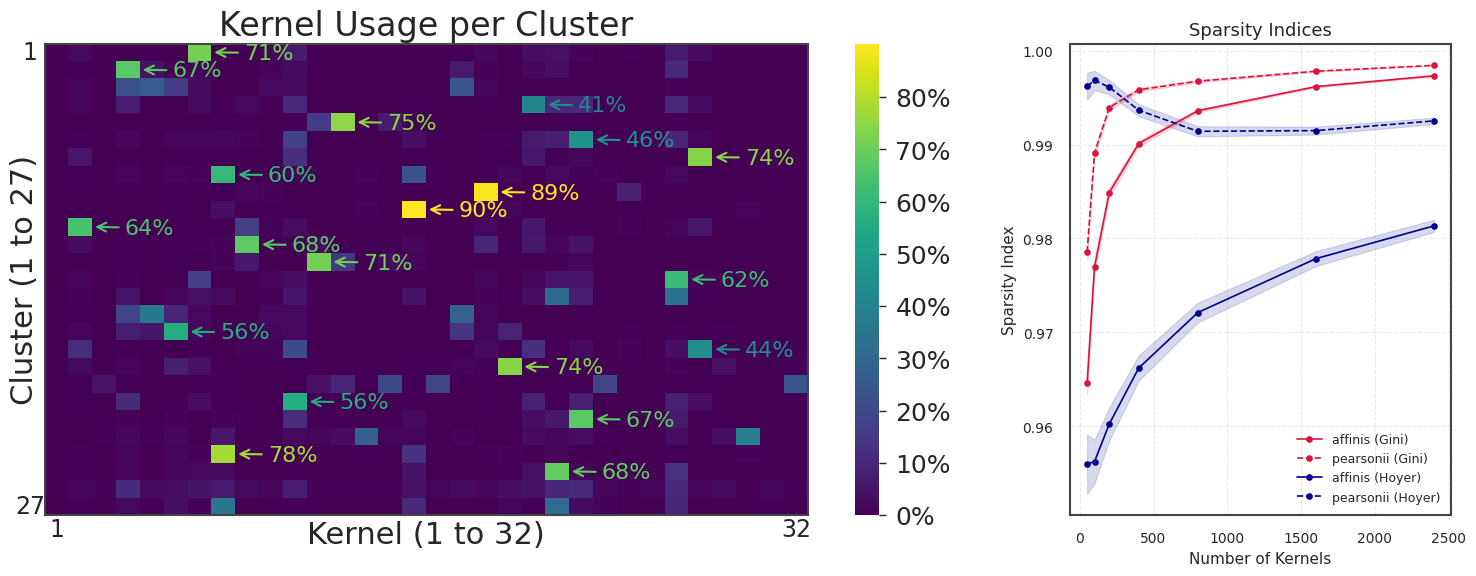

In [560]:
plot_cluster_heatmap_with_sparsity(
    file_kernel_count,
    df_reduced,
    clusters_raw,
    gini_aff,
    hoyer_aff,
    gini_pea,
    hoyer_pea,
    kernel_counts=[50, 100, 200, 400, 800, 1600, 2400]
)


In [745]:
def compute_gini(x):
    x = np.abs(np.asarray(x))
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = len(x_sorted)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x_sorted)) / (n * np.sum(x_sorted)) - (n + 1) / n

def compute_hoyer(x):
    x = np.abs(np.asarray(x))
    if np.all(x == 0):
        return 0.0
    l1 = np.sum(x)
    l2 = np.linalg.norm(x)
    n = len(x)
    return (np.sqrt(n) - l1 / l2) / (np.sqrt(n) - 1)

def compute_sparsity_for_top_n(df, n_kernels, extract_fn, group_col='filename'):
    gini_vals = []
    hoyer_vals = []

    grouped = df.groupby(group_col)

    for _, file_activations in tqdm(grouped):
        indices, amps, time_idxs = extract_fn(file_activations, n_kernels)

        amp_vector = np.zeros(n_kernels)
        for idx, amp in zip(indices, amps):
            if idx < n_kernels:
                amp_vector[idx] += np.abs(amp)

        gini_vals.append(compute_gini(amp_vector))
        hoyer_vals.append(compute_hoyer(amp_vector))

    result = {
        'gini': {
            'values': gini_vals,
            'mean': np.mean(gini_vals),
            'std': np.std(gini_vals)
        },
        'hoyer': {
            'values': hoyer_vals,
            'mean': np.mean(hoyer_vals),
            'std': np.std(hoyer_vals)
        }
    }

    return result



In [750]:
result = compute_sparsity_for_top_n(
    df, 
    n_kernels=250, 
    extract_fn=extract_mp_components,
    group_col='filename'  # or whatever column indicates the file
)

print("Gini mean:", result['gini']['mean'], "±", result['gini']['std'])
print("Hoyer mean:", result['hoyer']['mean'], "±", result['hoyer']['std'])


100%|██████████| 5907/5907 [00:05<00:00, 1056.64it/s]


Gini mean: 0.9860209130802448 ± 0.0075647874807098295
Hoyer mean: 0.9607484609833128 ± 0.024731075571771743
